# PROTAC-DB Data Cleaning



## Questions and Notes

**IMPORTANT:** In certain entries, I don't have the $DC_{50}$ value in nM, but I have the `Percent degradation (%)`, then the nM can be obtained from the Assay description!

**IDEA:** what about cleaning everything with two columns, one for the percentage (%) and one for the concentration (nM), and that's it? Afterall, $DC_{50}$ is just one value in the curve and some entries don't provide that exactly, but other points in the curve instead. Also, I can get additional degradation percentages and concentration from the Western Blot figures, only available online though (a web scraper might be solution)



### Dataset

* `Compound ID` is _not_ an ID, as there are multiple entries with the same ID. What makes them different might be the Uniprot ID.
* How do I make sure that the Database is the "largest one available"?
* What is a `receptor sequence`?
    * The POI Aminoacid sequence
* What is Western Blot data?
    * Another kind of experiment to evaluate the PROTACs degradation ability.
    * They might be useful for getting new data points, but they might add an additional dimension: not only cell type, but also the amount of time
* What's the differece between the `Target` and `Uniprot` columns? What do they refer to?
    * Uniprot ID refers to the POI, whereas `Target` is just the gene associated to the POI. **The `Target` information can actually be "looked up" in the Uniprot database given the Uniprot ID.**
* Can the Uniprot ID be obtained from the other columns?
    * If the `Target`, _i.e._, gene, column is reported, maybe it might be possible to extract or assume the Uniprot ID of the entry. There are around 72 entries in which the `Target` is specified while the `Uniprot` is missing.
    * Given a `Target`, we can estimate the Uniprot ID based on how is the `Target` assigned in other entries. For example by assigning the missing ones to the most frequent one.
* What is the cell type?
    * It is extracted from each row, it's the word preceeding the string " cells"
    * It seems that the cell type, being just a categorical feature, is not "informative enough" for guiding the model.
* Is the cell type extraction procedure "safe", _i.e._, error-free?
    * For now it should be fine, but for future updates of the dataset it might need some adjustments

### $DC_{50}$

From the paper:

> Degradation capacity: In general, $DC_{50}$ (concentration that results in a 50% targeted protein degradation) and $D_{max}$ (the maximal level of protein degradation) are utilized to quantify the power of targeted protein degradation of PROTACs. However, since a large number of PROTACs lacked the above data, the percentage degradation was also integrated into the database if it was assessed at least at two concentrations and at least two independent experiments were conducted for each concentration.

In general, the PROTAC-DB paper might have some of the answers about the DC50-related columns...

* What does $D_{max}$ value stand for? How different is from `Percent degradation (%)`?
    * It is the maximum degradation percentage, _i.e._, the degradation percentage at the highest concentration.
    * It is not always reported, but it can be obtained from the `Assay description` column (for some entries).
* What does the slash mean in the $DC_{50}$ value? Example: `8.5/6.3/9.2/11.4`
    * They might be either the different points in the degradation/concentration curve
    * Or they might refer to different cell types
    * Distinction is "resolved" if the entry is associated to more than one cell type (see section _Response Variable_ further down)
* What does the >, <, and ~ symbols mean in the $DC_{50}$ value? Examples: `1~3`, `>100`.
* Why is the $DC_{50}$ column saturated at a certain threshold? (Values higher than it will be set to the threshold value itself).
    * It might be because the experiment didn't see any particular difference in the degradation percentage when increasing the concentration. 
* Converting $DC_{50}$ to $pDC_{50}$?
    * It helps distributing the values in a "narrower range", overall improving the representation.
* ~~Some of the entries might have wrong or "absurd" or contradicting values in the `DC50 (nM)` and `Dmax (%)` columns! For instance, there is one entry where `DC50 (nM)` = 3.7/45, while `Dmax (%)` = 94/85. So for higher concentration (45), we would have higher_ $DC_{50}$, but instead we see a decrease (85)!~~
    * This behavior is referred to as _hook effect_

### Biochemistry Notes

Some notes about the biochemistry behind the PROTACs (it might contain some errors/silly statements, as I'm not a biochemist):

* A gene is a portion the DNA in the chomosome
* A gene starts and ends with a specific sequence
* A gene is "copied" to an mRNA, the mRNA (or something else?) then converts it to the protein
* 3 gene bases encode one aminoacid in the protein. An aminoacid can be encoded by several triplets (side note: the more triplets encode the same aminoacid, the less likely is that, in case of mutations, a different aminoacid is encoded)
* Genes can be slightly different in different organisms, that's why we have different uniprot ID, despite the gene reported in the entry is the same
* The cell type _might_ refer to the different cell type used for conducting the experiments. In fact, different cells might be difficult to handle/grow in lab. Also,  despite different cell types might use/have internally the same protein, the protein can be slightly different in different cells. Finally, the cell itself can influence the PROTAC response and in turn result in different DC50 values
* Intuitively, $IC_{50}$ in general measures how well two molecules bind togheter. That's why it is reported for different pairs, like E3-e3_ligase, Warhead-POI, et cetera.

### TODOs

* Include mutations for different genes for the same Uniprot ID
* ~~Check why number of Uniprot ID is different from number of gene entries~~
    * ~~I need to update the entries to include some _mutations_: they are not captured by the Uniprot ID, but should be easy to include~~
* ~~Normalize the concentration:~~
    1. ~~Convert nM to M~~
    2. ~~Take the negative logarithm~~

* ~~The cell type might be case insensitive, double check it with Eva~~
    * **The cell type is case sensitive**
* ~~Check if DS biased towards a certain E3~~
    * Yes, it is
* Web scraping degradation percentages from the Western Blot figures, which are only available online
* ~~Double check if the current DB is the "full one"~~
    * Yes, it is
* ~~Get finer details like canonical SMILES representation. (RDKit can get the canonal one)~~

activity cliffiness (prediction)?

## Cleaned PROTAC-DB Summary

| Column Name | Amount |
| --- | --- |
| Number of entries (any DC%) |  |
| Number of entries (previous work with DC50 only) |  |
| Unique PROTAC SMILES | 892 |
| Unique PROTAC canonical SMILES | 892 |
| Unique PROTAC canonical SMILES (removed stereo-chemistry) | 885 |
| Unique cell types | 150 |
| Unique genes/target | 97 |
| Unique POIs (Uniprot ID) | 88 |


## Setup and Imports

In [28]:
from IPython.display import display_html

import logging
import warnings
import re
import os
import numpy as np
import pandas as pd
import pickle
import sklearn.metrics
import pickle
import requests
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, MACCSkeys
from datetime import date
from typing import Literal, Optional, Union, List, Dict, Tuple, Any, Callable
from collections import defaultdict

Filter out some warnings...

In [29]:
def set_global_logging_level(level=logging.ERROR, prefices=[""]):
    """
    Override logging levels of different modules based on their name as a prefix.
    It needs to be invoked after the modules have been loaded so that their loggers have been initialized.

    Args:
        - level: desired level. e.g. logging.INFO. Optional. Default is logging.ERROR
        - prefices: list of one or more str prefices to match (e.g. ["transformers", "torch"]). Optional.
          Default is `[""]` to match all active loggers.
          The match is a case-sensitive `module_name.startswith(prefix)`
    """
    prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })')
    for name in logging.root.manager.loggerDict:
        if re.match(prefix_re, name):
            logging.getLogger(name).setLevel(level)

# Filter out annoying Pytorch Lightning printouts
warnings.filterwarnings('ignore', '.*Covariance of the parameters could not be estimated.*')
warnings.filterwarnings('ignore', '.*You seem to be using the pipelines sequentially on GPU.*')

Setup working directories:

In [30]:
data_dir = os.path.join(os.getcwd(), '..', 'data')
src_dir = os.path.join(os.getcwd(), '..', 'src')
fig_dir = os.path.join(data_dir, 'figures')
checkpoint_dir = os.path.join(os.getcwd(), '..', 'checkpoints')
dirs_to_make = [
    data_dir,
    os.path.join(data_dir, 'raw'),
    os.path.join(data_dir, 'processed'),
    os.path.join(data_dir, 'train'),
    os.path.join(data_dir, 'val'),
    os.path.join(data_dir, 'test'),
    src_dir,
    fig_dir,
    checkpoint_dir,
]
for d in dirs_to_make:
    if not os.path.exists(d):
        os.makedirs(d)

Download or load the raw PROTAC-DB dataset:

In [31]:
protacdb_file = os.path.join(data_dir, 'raw', 'protac.csv')
protacdb_url = 'http://cadd.zju.edu.cn/protacdb/statics/binaryDownload/csv/protac/protac.csv'
if os.path.exists(protacdb_file):
    protac_df = pd.read_csv(protacdb_file).reset_index(drop=True)
    print(f'Loaded protac.csv')
else:
    print(f'Downloading {protacdb_url}')
    !wget {protacdb_url} {protacdb_file}
    protac_df = pd.read_csv(protacdb_file).reset_index(drop=True)
    print(f'PROTAC-DB loaded')

Loaded protac.csv


## POI

### Handling Rows with no Uniprot ID

TODO: Substituting the most frequent ones currently doesn't work, since the Targets missing Uniprot never show up anywhere else... (and so it's impossible to count them)

In [32]:
n_target = protac_df.shape[0] - protac_df['Target'].isna().sum()
n_uniprot = protac_df.shape[0] - protac_df['Uniprot'].isna().sum()
print('Number of entries with Target:', n_target)
print('Number of entries with UniprotID (before attempt):', n_uniprot)
# Given a unique Target, get its most frequent Uniprot
most_freq_uniprot = protac_df.groupby('Target')['Uniprot'].agg(lambda x: x.value_counts().index).to_dict()
# Remove non-string values
tmp = most_freq_uniprot.copy()
for k, v in tmp.items():
    if type(tmp[k]) != str:
        del most_freq_uniprot[k]
# Update the missing Uniprot entries
protac_df['Uniprot'].fillna(protac_df['Target'].map(most_freq_uniprot), inplace=True)
# Check whether the Target and Uniprot column sizes now match
n_uniprot = protac_df.shape[0] - protac_df['Uniprot'].isna().sum()
print('Number of entries with UniprotID (after attempt):', n_uniprot)

Number of entries with Target: 5388
Number of entries with UniprotID (before attempt): 5196
Number of entries with UniprotID (after attempt): 5196


TODO: Checking the assay description in order to eventually find the missing information. Maybe using [Cellosaurus](https://www.cellosaurus.org/)?

In [33]:
no_uniprot_df = protac_df.loc[protac_df['Uniprot'].isna() & (~protac_df['Assay (DC50/Dmax)'].isna() | ~protac_df['Assay (Percent degradation)'].isna()), :] #['Assay (Percent degradation)', 'Assay (DC50/Dmax)', 'Article DOI']]
no_uniprot_df = protac_df.loc[protac_df['Uniprot'].isna(), :] #['Assay (Percent degradation)', 'Assay (DC50/Dmax)', 'Article DOI']]
no_uniprot_df[['Assay (Percent degradation)', 'Assay (DC50/Dmax)', 'Article DOI']]

,Assay (Percent degradation),Assay (DC50/Dmax),Article DOI
463,NaN,NaN,10.1002/anie.201507634
464,NaN,NaN,10.1002/anie.201507634
465,NaN,NaN,10.1002/anie.201507634
466,NaN,NaN,10.1002/anie.201507634
467,NaN,NaN,10.1002/anie.201507634
...,...,...,...
5203,NaN,NaN,10.1016/j.apsb.2020.11.009
5204,NaN,NaN,10.1016/j.apsb.2020.11.009
5205,NaN,NaN,10.1016/j.apsb.2020.11.009
5384,NaN,NaN,10.1021/jacs.1c03980


In [34]:
for i, doi in enumerate(no_uniprot_df['Article DOI'].unique()):
    # print(f'Article n.{i+1} DOI: {doi}')
    print(f'{doi}')

10.1002/anie.201507634
10.1021/acs.jmedchem.9b01264
10.1021/acs.jmedchem.0c00967
10.1016/j.bmc.2011.09.041
10.1016/j.bmcl.2016.09.041
10.1158/0008-5472.CAN-19-1236
10.1111/cas.13284
10.1021/acsmedchemlett.7b00247
10.1074/jbc.M116.768853
10.3390/cells9051083
10.1038/s41467-019-11429-w
10.1021/acs.jmedchem.9b02058
10.1021/acschembio.0c00348
10.1039/d0cc02201b
10.1016/j.ejmech.2021.113645
10.1016/j.ejmech.2021.114013
10.1016/j.bmcl.2022.128584
10.1016/j.apsb.2020.11.009
10.1021/jacs.1c03980


Missing Uniprot entries are filled with "Unknown":
<!-- Remove missing `Uniprot` entries. -->

In [35]:
protac_df = protac_df.fillna(value={'Uniprot': 'Unknown'})
print('protac_df: {:,} x {:,}'.format(*protac_df.shape))
# protac_df = protac_df.dropna(subset=['Uniprot'])

protac_df: 5,388 x 89


The Target is actually the *gene name* of the target, the Uniprot ID in reality is enough the get all the information needed.

In [36]:
protac_df.loc[:, ['Uniprot', 'Target']].head()

,Uniprot,Target
0,Q9NPI1,BRD7
1,Q9H8M2,BRD9
2,Q9NPI1,BRD7
3,Q9H8M2,BRD9
4,Q9H8M2,BRD9


The Uniprot ID will be used to get the protein sequence. The gene ID will be instead used to apply specific mutations to the protein sequence. In fact, multiples genes might refer to the same protein, but with different mutations.

(A protein can be uniquely identified by the gene that synthesizes it then, I guess?)

In [37]:
old2new_names = {'Target': 'poi_gene_id'}
protac_df = protac_df.rename(columns=old2new_names)

### Get Amino Acid Sequence

Scrape FASTA sequence from UniProt database.

NOTE: The Uniprot ID can be referring to both E3 and POI target, but we assume it's referring to the POI target.

In [38]:
poi_sequences_filepath = os.path.join(data_dir, 'processed', 'poi_sequences.pkl')
failed = False
if os.path.exists(poi_sequences_filepath):
    with open(poi_sequences_filepath, 'rb') as f:
        seqs = pickle.load(f)
else:
    cID = list(set(protac_df['Uniprot'].tolist()))
    seqs = {}
    for c in cID:
        try:
            baseUrl = 'http://www.uniprot.org/uniprot/'
            currentUrl = baseUrl + c + '.fasta'
            response = requests.post(currentUrl)
            cData = ''.join(response.text)
            i = cData.index('\n') + 1
            seq = cData[i:].rstrip().replace('\n', '')
            seqs[c] = seq
            # print(f'Getting {cData} from URL: {currentUrl}')
        except:
            print(f'Error getting {c} from URL: {currentUrl}')
            failed = True
    if not failed:
        with open(poi_sequences_filepath, 'wb') as f:
            pickle.dump(seqs, f)
# Add 'Unknown' sequences corresponding to 'Unknown' genes/POIs
seqs['Unknown'] = 'Unknown'

In [39]:
# protac_df['poi_seq'] = protac_df.apply(lambda row: seqs[row['Uniprot']], axis=1)
protac_df['poi_seq'] = protac_df['Uniprot'].map(seqs)

### Applying Gene Mutations

For the same Uniprot ID, we might have different gene mutations, as illustrated as follows:

In [40]:
grouped_data = protac_df.groupby('Uniprot')['poi_gene_id'].apply(lambda x: ', '.join(x.unique()))
for i, (uniprotid, genes) in enumerate(zip(grouped_data.index, grouped_data)):
    if len(genes.split(',')) > 1:
        print(f'{i:3d}) Num.{len(genes.split(",")):2d} genes per {uniprotid}: {genes}')

 20) Num. 2 genes per O60674: JAK2, JAK2 R683G
 22) Num. 2 genes per O60885: BRD4, BRD4 BD1
 26) Num. 2 genes per O75533: SF3B1, SF3B1 K400E
 34) Num. 7 genes per P00533: EGFR, EGFR L858R/T790M, EGFR e19d, EGFR L858R, EGFR L858R/T790M/C797S, EGFR L858R/T790M/L718Q, EGFR del19/T790M/C797S
 36) Num. 2 genes per P01116: KRAS G12C, KRAS
 51) Num. 3 genes per P10275: AR, AR-V7, AR T878A
 62) Num. 8 genes per P15056: BRAF, BRAF V600E, BRAF V600K, BRAF K601E, BRAF G466E, BRAF D594N, BRAF G466V, BRAF G469A
 73) Num. 2 genes per P25440: BRD2, BRD2 BD2
 90) Num. 4 genes per P36888: FLT3, FLT3-ITD, FLT3-ITD-D835V, FLT3-ITD-F691L
138) Num. 2 genes per P62942: FKBP12, FKBP12 F36V
149) Num. 2 genes per Q06124: SHP2, SHP2 F285S
150) Num. 6 genes per Q06187: BTK, BTK C481S, BTK C481T, BTK C481G, BTK C481W, BTK C481A
177) Num. 2 genes per Q15059: BRD3, BRD3 BD1
253) Num. 2 genes per Q9NYV4: CDK12, CDK12 C1039F
265) Num. 2 genes per Q9UM73: ALK, ALK G1202R
273) Num.17 genes per Unknown: BCR-ABL, RAR, PD

AR-V7, for instance, has different "splicing variance", meaning that the aminoacid sequence might be "very" dfferent, _i.e._ instead of differ by just one or a few letters, they might instead have entire different "chucks" of letters.

NOTE: Indexing starts from one! Not zero!

In [41]:
def apply_mutation(uniprot: str, gene: str, seq: str, on_error: Literal['raise', 'ignore'] = 'raise') -> str:
    """Apply the mutation to the sequence, if possible."""
    if gene == 'Unknown' or seq == 'Unknown':
        return seq
    if len(gene.split(' ')) == 1:
        return seq
    if gene.startswith('BRD'):
        return seq
    # TODO: Just use a dictionary and replace these sequences straightaway...
    exceptions = {
        ('O60885', 'BRD4 BD1'): seqs['O60885'],
        ('P25440', 'BRD2 BD2'): seqs['P25440'],
        ('P10275', 'AR-V7'): seqs['P10275'],
        ('P00533', 'EGFR e19d'): seqs['P10275'], # TODO: Not working... why???
    }
    if (uniprot, gene) in exceptions:
        return exceptions[(uniprot, gene)]
    else:
        original_seq = seq
        mutation = gene.split(' ')[1]
        operations = mutation.split('/') if '/' in mutation else [mutation]
        del_ops = 0
        # print(f'Applying mutation {mutation} from gene {gene} to {uniprot}... sequence: {seq}')
        for op in operations:
            if 'del' in op.lower():
                idx = int(op.split('del')[1]) - 1
                print(f'Operation: {op} on ...{seq[idx-8:idx]}[{seq[idx]}]{seq[idx+1:idx+8]}...')
                seq = seq[:idx] + seq[idx + 1:]
                del_ops += 1
            else:
                # Replace aminoacid at a specific index
                # NOTE: The indexing starts from one, not zero.
                # NOTE: If a deletion has happened before, the index is still
                # relative to the whole sequence lenght (weird...)
                curr, idx, new = op[0].upper(), int(op[1:-1])-1, op[-1].upper()
                idx -= del_ops
                print(f'Operation: {op} on ...{seq[idx-8:idx]}[{seq[idx]} -> {new}]{seq[idx+1:idx+8]}...')
                if curr != seq[idx]:
                    msg = f'Replacement at position {idx} failed. Expected "{curr}", found: "{seq[idx]}".'
                    if on_error == 'raise':
                        raise ValueError('ERROR. ' + msg)
                    else:
                        print('WARNING. ' + msg + ' No mutation is applied.')
                        return original_seq
                seq = seq[:idx] + new + seq[idx + 1:]
        return seq

example = protac_df.loc[protac_df['poi_gene_id'] == 'EGFR L858R/T790M', ['Uniprot', 'poi_gene_id', 'poi_seq']].iloc[0]
uniprot, gene, seq = example['Uniprot'], example['poi_gene_id'], example['poi_seq']
print(seq)
print(apply_mutation(uniprot, gene, seq, on_error='ignore'))
print(apply_mutation(uniprot, 'EGFR del19/T790M/C797S', seq, on_error='ignore'))
print(apply_mutation(uniprot, 'EGFR', seq, on_error='ignore'))

MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRA

Apply mutations to POI sequences:

TODO: Some mutations are still failing... ignoring them for now...

In [42]:
protac_df.loc[:, 'poi_seq'] = protac_df.apply(lambda row: apply_mutation(row['Uniprot'], row['poi_gene_id'], row['poi_seq'], on_error='ignore'), axis=1)

Operation: C481S on ...ITEYMANG[C -> S]LLNYLRE...
Operation: C481S on ...ITEYMANG[C -> S]LLNYLRE...
Operation: G1202R on ...ILLELMAG[G -> R]DLKSFLR...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...

## SMILES

### Converting to Canonical SMILES

In [43]:
tmp = protac_df.dropna(subset=['Smiles'])
print(f"Number of entries with SMILES: {len(tmp)}")
print(f"Number of unique SMILES: {len(tmp['Smiles'].unique())}")

Number of entries with SMILES: 5388
Number of unique SMILES: 3270


In [44]:
canonize_smiles = lambda smiles: Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
protac_df['Smiles'] = protac_df['Smiles'].apply(canonize_smiles)

Another possible approach:

In [45]:
from rdkit import Chem

myPattern = 'c1ccc2c(c1)c3ccccc3[nH]2'
myMolecule = 'C1=CC=C2C(=C1)C3=CC=CC=C3N2'

a = Chem.CanonSmiles(myPattern)
b = Chem.CanonSmiles(myMolecule)

print(a)
# 'c1ccc2c(c1)[nH]c1ccccc12'
print(b)
# 'c1ccc2c(c1)[nH]c1ccccc12'
print(a == b)
# True### Removing Stereo-Chemistry Information

c1ccc2c(c1)[nH]c1ccccc12
c1ccc2c(c1)[nH]c1ccccc12
True


### Removing Stereo-Chemistry Information

Add a column for the removed stereo-chemistry. 

* TODO: RDKit should be able to tell if two molecules are the same.
* TODO: We might want to remove non-unique SMILES (w/out stereochemistry) that have a low degradation percentage, _i.e._ "low activation".

Stackoverflow: https://chemistry.stackexchange.com/questions/163225/how-to-use-python-rdkit-to-remove-stereochemistry-salts-and-molecules-with-unde

* RDkit cookbook: https://www.rdkit.org/docs/Cookbook.html#identifying-stereochemistry
* RDkit blog: https://greglandrum.github.io/rdkit-blog/
* RDkit another blog: https://iwatobipen.wordpress.com/ 
* RDkit another another blog: http://practicalcheminformatics.blogspot.com/?_sm_au_=iVVNqD0fNPRvPzt4pGsWvKttvN1NG

In [46]:
def remove_stereochemistry(smiles):
    mol = Chem.MolFromSmiles(smiles)
    Chem.RemoveStereochemistry(mol) # NOTE: It's a void function (returns None)
    return Chem.MolToSmiles(mol)

smiles = protac_df.loc[0, 'Smiles']
print(smiles)
print(remove_stereochemistry(smiles))

COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=O)NCc2ccc(-c3scnc3C)cc2)C(C)(C)C)CC1
COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)NC(C(=O)N2CC(O)CC2C(=O)NCc2ccc(-c3scnc3C)cc2)C(C)(C)C)CC1


Perform the actual stereo-chemistry removal:

In [47]:
remove_stereo = lambda smiles: remove_stereochemistry(smiles)
protac_df['Smiles_nostereo'] = protac_df['Smiles'].apply(remove_stereo)

## E3 Ligase

Rename the E3 Ligase column to make it easier to handle later on:

In [48]:
old2new_names = {'E3 ligase': 'e3_ligase'}
protac_df = protac_df.rename(columns=old2new_names)

Plotting the distribution of the E3 Ligase classes:

column: e3_ligase  (#unique: 13)
             0     1      2     3     4    5    6      7       8       9   \
e3_ligase  CRBN   VHL  cIAP1  MDM2  XIAP  IAP  AhR  FEM1B  DCAF15  DCAF16   
size       3530  1578     95    56    49   46    9      9       4       4   

               10      11    12  
e3_ligase  RNF114  DCAF11  RNF4  
size            4       3     1   



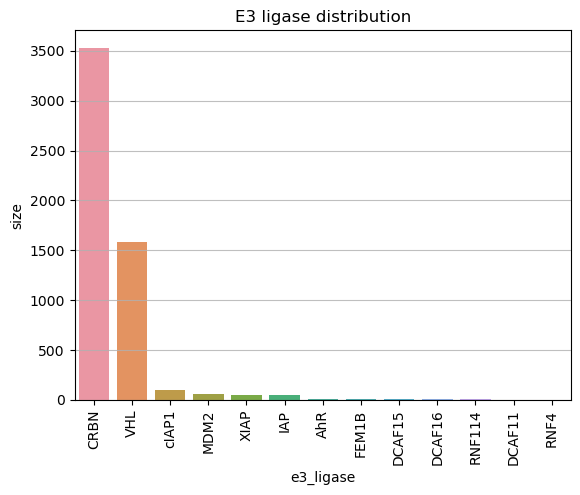

In [49]:
tmp = protac_df.groupby('e3_ligase', as_index=False).size().sort_values('size', ascending=False, ignore_index=True)
print(f'column: e3_ligase  (#unique: {tmp.shape[0]:,})')
print(tmp.head(20).T, '\n')
# Plotting
sns.barplot(data=tmp, x='e3_ligase', y='size')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.8)
plt.title(f'E3 ligase distribution')
plt.show()

In [50]:
print(f'E3 ligase names: {protac_df["e3_ligase"].unique()}')

E3 ligase names: ['VHL' 'CRBN' 'DCAF15' 'MDM2' 'cIAP1' 'XIAP' 'DCAF16' 'AhR' 'IAP' 'RNF4'
 'RNF114' 'DCAF11' 'FEM1B']


Assigning the gene ID to the E3 ligase entries:

In [51]:
e3ligase2genes = {
    'VHL': 'P40337',
    'CRBN': 'Q96SW2',
    'DCAF11': 'Q8TEB1',
    'DCAF15': 'Q66K64',
    'DCAF16': 'Q9NXF7',
    'MDM2': 'Q00987',
    'XIAP': 'P98170',
    'cIAP1': 'Q7Z460',
    'IAP': 'P98170', # I couldn't find the Uniprot ID for this one, so it's XIAP
    'AhR': 'P35869',
    'RNF4': 'P78317',
    'RNF114': 'Q9Y508',
    'FEM1B': 'Q9UK73',
}
protac_df['e3_ligase_gene'] = protac_df['e3_ligase'].map(e3ligase2genes)
protac_df['e3_ligase_gene']

0       P40337
1       P40337
2       P40337
3       P40337
4       Q96SW2
         ...  
5383    Q9UK73
5384    Q9UK73
5385    Q9UK73
5386    Q96SW2
5387    Q96SW2
Name: e3_ligase_gene, Length: 5388, dtype: object

In [52]:
e3_ligase_sequences_filepath = os.path.join(data_dir, 'processed', 'e3_ligase_sequences.pkl')
failed = False
if os.path.exists(e3_ligase_sequences_filepath):
    with open(e3_ligase_sequences_filepath, 'rb') as f:
        e3_seqs = pickle.load(f)
else:
    cID = list(set(protac_df['e3_ligase_gene'].tolist()))
    e3_seqs = {}
    for c in cID:
        baseUrl = 'http://www.uniprot.org/uniprot/'
        currentUrl = baseUrl + c + '.fasta'
        try:
            response = requests.post(currentUrl)
            cData = ''.join(response.text)
            i = cData.index('\n') + 1
            seq = cData[i:].rstrip().replace('\n', '')
            e3_seqs[c] = seq
            # print(f'Getting {cData} from URL: {currentUrl}')
        except:
            print(f'Error getting {c} from URL: {currentUrl}')
            failed = True
    if not failed:
        with open(e3_ligase_sequences_filepath, 'wb') as f:
            pickle.dump(e3_seqs, f)
# Add 'Unknown' sequences corresponding to 'Unknown' genes/POIs
e3_seqs['Unknown'] = 'Unknown'

In [53]:
protac_df['e3_ligase_seq'] = protac_df['e3_ligase_gene'].map(e3_seqs)
protac_df['e3_ligase_seq'].head()

0    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...
1    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...
2    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...
3    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...
4    MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...
Name: e3_ligase_seq, dtype: object

Combining sub-classes of E3 together:

In [54]:
for i in range(len(protac_df['e3_ligase'])):
    if 'IAP' in str(protac_df.iloc[i].at['e3_ligase']):
        protac_df.at[i, 'e3_ligase'] = 'IAP'
    elif 'DCAF' in str(protac_df.iloc[i].at['e3_ligase']):
        protac_df.at[i, 'e3_ligase'] = 'DCAF'
    elif 'RNF' in str(protac_df.iloc[i].at['e3_ligase']):
        protac_df.at[i, 'e3_ligase'] = 'RNF'

Plotting the distribution of the aggregated E3 Ligase classes:

column: e3_ligase  (#unique:8)
              0     1    2     3     4    5      6    7
e3_ligase  CRBN   VHL  IAP  MDM2  DCAF  AhR  FEM1B  RNF
size       3530  1578  190    56    11    9      9    5 



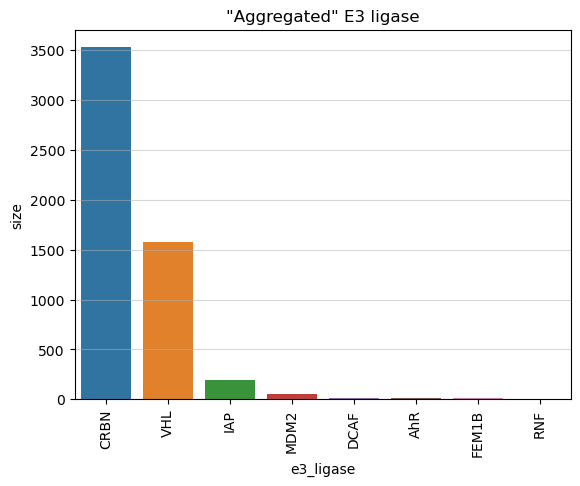

In [55]:
tmp = protac_df.groupby('e3_ligase', as_index=False).size().sort_values('size', ascending=False, ignore_index=True)
print(f"column: {'e3_ligase'}  (#unique:{tmp.shape[0]:,})")
print(tmp.head(20).T, "\n")
# Plotting
sns.barplot(data=tmp.head(25), x='e3_ligase', y='size')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.5)
plt.title(f'"Aggregated" E3 ligase')
plt.show()
del tmp

## Assay Description Parsing Function

For each entry, there are two  scenarios possible:

* Each value separated by the slashes in the `DC50 (nM)` column represents the $DC_{50}$ value collected for a specific cell type or POI
    * Example: "Degradation of AR in A549/LNCaP cells after 24 h treatment"
* Each value separated by the slashes in the `Percent degradation (%)` column represents the degradation percentage in a _single_ cell at different concentrations (in nM).
    * Example: "% AR degradation in LNCaP cells after 6 h treatment at 10/100/1000 nM"
    * Here, "hook effect" entries might occur, _i.e._, where with higher concentrations we instead see lower degradation percentanges
    * For two entries (just two! Imagine how sick and messy this dataset can get!) the slashes correspond to different POIs:
        * Example: "% EGFR L858R/T790M degradation in H1975 cells after 24 h treatment at 100/1000 nM"
        * Example: "% EGFR L858R/T790M degradation in H1975 cells after 24 h treatment at 10/100 nM"

Hence, we an advanced method to parse information from assays such as the following ones:

In [56]:
for i, a in enumerate(protac_df['Assay (DC50/Dmax)'].unique()):
    print(a)
    if i > 20:
        break
print('-' * 80)
for i, a in enumerate(protac_df['Assay (Percent degradation)'].unique()):
    print(a)
    if i > 20:
        break

nan
Degradation of BRD9 in HeLa cells after 4 h treatment
Degradation of BRD9 in RI-1 cells after 8 h treatment
Degradation of HiBiT-BRD9 in HEK293 cells after 24 h treatment using CRISPR/Cas9
Degradation of BRD9 in EOL-1/A-204 cells after 18 h treatment on a WES capillary electrophoresis instrument
Degradation of BRD7 in RI-1 cells after 8 h treatment
Degradation of HiBiT-BRD7 in HEK293 cells after 24 h treatment using CRISPR/Cas9
Degradation of ER in MCF-7/T47D cells after 4 h treatment
Degradation of AR in LNCaP/VCaP AR+ cells after 6 h treatment
Degradation of AR in LNCaP/VCaP/22Rv1 cells after 24 h treatment
Degradation of BRD4 in NCI-H661/NCI-H838 cells after 4h treatment
Degradation of CRBN in HEK293T cells after 24h treatment
Degradation of CRBN in MM1S cells after 24h treatment
Degradation of p38alpha in MDA-MB-231 cells
Degradation of p38delta in MDA-MB-231 cells
Degradation of p38alpha in MDA-MB-231 cells after 24 h treatment
Degradation of BRD2
Degradation of BRD3
Degradati

In [57]:
# Replace with the cell line accession number you are interested in
cellosaurus_api = 'https://web.expasy.org/cellosaurus/api/search/cell-line'

query = 'RS4;11'
url = f'{cellosaurus_api}?q={query.rstrip()}&fields=id,sy,idsy'

response = requests.get(url)

if response.status_code == 200:
    search_results = response.json()
    print(search_results)

    for k in search_results:
        print(search_results[k])
        for k2 in search_results[k]:
            print(k2, search_results[k][k2])
            for l in search_results[k][k2]:
                print(l)
else:
    print('Request failed with status code', response.status_code)

{'Cellosaurus': {'cell-line-list': [{'name-list': [{'type': 'identifier', 'value': 'RS4;11'}, {'type': 'synonym', 'value': 'RS4-11'}, {'type': 'synonym', 'value': 'RS4:11'}, {'type': 'synonym', 'value': 'RS 4;11'}, {'type': 'synonym', 'value': 'RS(4;11)'}, {'type': 'synonym', 'value': 'RS411'}, {'type': 'identifier', 'value': 'RS4;11'}, {'type': 'synonym', 'value': 'RS4-11'}, {'type': 'synonym', 'value': 'RS4:11'}, {'type': 'synonym', 'value': 'RS 4;11'}, {'type': 'synonym', 'value': 'RS(4;11)'}, {'type': 'synonym', 'value': 'RS411'}]}, {'name-list': [{'type': 'identifier', 'value': 'RS4;11 BCL2-F104L'}, {'type': 'identifier', 'value': 'RS4;11 BCL2-F104L'}]}, {'name-list': [{'type': 'identifier', 'value': 'RS4;11 BCL2-G101V'}, {'type': 'identifier', 'value': 'RS4;11 BCL2-G101V'}]}]}}
{'cell-line-list': [{'name-list': [{'type': 'identifier', 'value': 'RS4;11'}, {'type': 'synonym', 'value': 'RS4-11'}, {'type': 'synonym', 'value': 'RS4:11'}, {'type': 'synonym', 'value': 'RS 4;11'}, {'type

The following model was obtained from this [🤗 repo](https://huggingface.co/tlemberger/sd-ner).

**TODO:** The cell types are not consistent, meaning that the same cell is called in different ways, _e.g._, 'PACA-2' and 'PACA2'.

In [58]:
import torch
from transformers import (pipeline,
                          RobertaTokenizerFast,
                          RobertaForTokenClassification)

if torch.cuda.is_available():
    device = 0
else:
    device = torch.device('cpu')

tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_len=512)
# model = RobertaForTokenClassification.from_pretrained('EMBO/sd-ner')
model = RobertaForTokenClassification.from_pretrained('tlemberger/sd-ner')
ner = pipeline('ner', model, tokenizer=tokenizer, device=device)

In [59]:
label2entity = {
    'LABEL_0': 'O',
    'LABEL_1': 'I-SMALL_MOLECULE',
    'LABEL_2': 'B-SMALL_MOLECULE',
    'LABEL_3': 'I-GENEPROD',
    'LABEL_4': 'B-GENEPROD',
    'LABEL_5': 'I-SUBCELLULAR',
    'LABEL_6': 'B-SUBCELLULAR',
    'LABEL_7': 'I-CELL',
    'LABEL_8': 'B-CELL',
    'LABEL_9': 'I-TISSUE',
    'LABEL_10': 'B-TISSUE',
    'LABEL_11': 'I-ORGANISM',
    'LABEL_12': 'B-ORGANISM',
    'LABEL_13': 'I-EXP_ASSAY',
    'LABEL_14': 'B-EXP_ASSAY',
}

# TODO: The following should be a dictionary of lists of possible synonyms. For
# example the cells 'PACA-2' and 'PACA2' should be identified as the same one!

# Add the following cells if one-to-one match in input text
undetected_cells = {
    'XLA': ['XLA'],
    # 'EGFP/mCherry': ['EGFP/mCherry'],
    'Ba/F3': ['Ba/F3'],
    'Mino': ['Mino'],
    'IgE MM': ['IgE MM'],
    'IL2 PBMC': ['IL2 PBMC'],
}

# Remove the following cells if one-to-one match in input text
false_pos_cells = {
    'BA',
    'F3',
    'DEL19',
}

false_pos_genes = {
    'IL2',
}

# The key will be the final gene ID to add, the value will be a list of possible
# synonyms in the text to match
undetected_genes = {
    'BRD4 short': ['BRD4 short'],
    'BRD4 long': ['BRD4 short/long'],
    'EGFR L858R': ['EGFR L858R'],
    'T790M': ['T790M'],
}

def parse_assay_text(input_text):
    parsed_info = {}
    # Separate the cell types with a "stronger" token like "and", instead of "/"
    cleaned_text = input_text.replace('/', ' and ')
    # Run Named Entity Recognition on it
    labeled_text = ner(cleaned_text)
    # Aggregate the cell-labeled sub-words/tokens into words
    lst2str = lambda lst: ''.join(lst).replace('Ġ', '')
    genes, gene_word = [], []
    cells, cell_word = [], []
    for token in labeled_text:
        # Process Cell-labeled tokens
        if '-CELL' in label2entity[token['entity']]:
            cell_word.append(token['word'])
        if 'O' == label2entity[token['entity']] and cell_word != []:
            cells.append(lst2str(cell_word).upper())
            cell_word = []
        # Process Gene-labeled tokens
        if 'GENE' in label2entity[token['entity']]:
            gene_word.append(token['word'])
        if 'O' == label2entity[token['entity']] and gene_word != []:
            genes.append(lst2str(gene_word).upper())
            gene_word = []
    # Add missing genes
    for geneid, synonyms in undetected_genes.items():
        for gene in synonyms:
            if gene in input_text and gene.upper() not in genes:
                genes.append(geneid)
    # Handle special cases...
    if 'short/long' in input_text.lower() and 'BRD4' in genes:
        genes.remove('BRD4')
    if 'EGFR' in genes:
        genes.remove('EGFR')
    # Remove false-positives genes
    for gene in false_pos_genes:
        if gene in genes:
            genes.remove(gene)
    # Add missing cell types
    for cellid, synonyms in undetected_cells.items():
        for cell in synonyms:
            if cell in input_text and cell.upper() not in cells:
                cells.append(cellid)
    # Remove false-positives cells
    for cell in false_pos_cells:
        if cell in cells:
            cells.remove(cell)
    # Fill default if not found
    if cells == []:
        cells = ['Unknown']
    if genes == []:
        genes = ['Unknown']
    # Parse treatment time from assay description
    if 'after' in input_text.lower() and 'h treatment' in input_text.lower():
        time_str = input_text.lower().split('after')[1].split('treatment')[0]
        treatment_hours = re.findall(r'\d+', time_str)
    else:
        treatment_hours = ['Unknown']
    # Parse concentration for entries not displaying DC50
    if re.search(f'at [0-9.\/]+', input_text.lower()):
        search_txt = input_text.split('at')[-1]
        if 'nM' in search_txt:
            concentrations = re.findall(r'[0-9.]+', search_txt)
        else:
            concentrations = ['Unknown']
    else:
        concentrations = ['Unknown']
    # Store all parsed information in a dictionary
    parsed_info['genes'] = genes
    parsed_info['cells'] = cells
    parsed_info['treatment_hours'] = treatment_hours
    parsed_info['concentrations'] = concentrations
    return parsed_info

# NOTE: One entry has a SPACE(!) in "RS4; 11", but the cell type is "RS4;11" 
example = 'Degradation of BCL-xL in MOLT-4/RS4; 11 cells'
parsed_info = parse_assay_text(example)
genes, cells = parsed_info['genes'], parsed_info['cells']
print(f'POI from genes {"/".join(genes)} degraded in cells: {"/".join(cells)}. Info: {parsed_info}')

# DC50 (nM) -> 100/1000
example = 'Degradation of ALK in H3122/Karpas 299 cells' # Assay DC50 
parsed_info = parse_assay_text(example)
genes, cells = parsed_info['genes'], parsed_info['cells']
print(f'POI from genes {"/".join(genes)} degraded in cells: {"/".join(cells)}. Info: {parsed_info}')

example = 'Degradation of BRD4 short/long in HeLa cells at 24 h treatment'
parsed_info = parse_assay_text(example)
genes, cells = parsed_info['genes'], parsed_info['cells']
print(f'POI from genes {"/".join(genes)} degraded in cells: {"/".join(cells)}. Info: {parsed_info}')

# DC (%) -> 40/75/43
example = '% AR degradation in LNCaP cells after 6 h at 0.1/1000/10000 nM'
example = '% AR degradation in LNCaP cells after 6 h treatment at 0.1/1000/10000 nM'
parsed_info = parse_assay_text(example)
genes, cells = parsed_info['genes'], parsed_info['cells']
print(f'POI from genes {"/".join(genes)} degraded in cells: {parsed_info}')

# 'EGFR L858R/T790M' -> ['EGFR L858R', 'T790M']
example = '% EGFR L858R/T790M degradation in H1975 cells after 24 h treatment at 10/100 nM'
parsed_info = parse_assay_text(example)
genes, cells = parsed_info['genes'], parsed_info['cells']
print(f'POI from genes {"/".join(genes)} degraded in cells: {parsed_info}')

example = 'Inhibit IFNgamma signalling in IL2 PBMC cells'
parsed_info = parse_assay_text(example)
genes, cells = parsed_info['genes'], parsed_info['cells']
print(f'POI from genes {"/".join(genes)} degraded in cells: {parsed_info}')

POI from genes BCL-XL degraded in cells: MOLT-4/RS4;11. Info: {'genes': ['BCL-XL'], 'cells': ['MOLT-4', 'RS4;11'], 'treatment_hours': ['Unknown'], 'concentrations': ['Unknown']}
POI from genes ALK degraded in cells: H3122/KARPAS299. Info: {'genes': ['ALK'], 'cells': ['H3122', 'KARPAS299'], 'treatment_hours': ['Unknown'], 'concentrations': ['Unknown']}
POI from genes BRD4 short/BRD4 long degraded in cells: HELA. Info: {'genes': ['BRD4 short', 'BRD4 long'], 'cells': ['HELA'], 'treatment_hours': ['Unknown'], 'concentrations': ['Unknown']}
POI from genes AR degraded in cells: {'genes': ['AR'], 'cells': ['LNCAP'], 'treatment_hours': ['6'], 'concentrations': ['0.1', '1000', '10000']}
POI from genes EGFR L858R/T790M degraded in cells: {'genes': ['EGFR L858R', 'T790M'], 'cells': ['H1975'], 'treatment_hours': ['24'], 'concentrations': ['10', '100']}
POI from genes IFNGAMMA degraded in cells: {'genes': ['IFNGAMMA'], 'cells': ['PBMC', 'IL2 PBMC'], 'treatment_hours': ['Unknown'], 'concentrations':

## Degradation Activity: $pDC_{50}$ and $D_{max}$

Now the "messy part" begins. We need to clean the degradation activity data. To do so, we need to:

* Define a set of parsing functions to extract information from the "Assay Description" columns
* Setup different dataframes to store the entries with missing information


Create a global dictionary to store the dataframes as list of dictionaries (i.e., one dictionary per row):

In [60]:
dataframes = defaultdict(pd.DataFrame)
dataframes

defaultdict(pandas.core.frame.DataFrame, {})

### Entries with N.D. (Not Degrading)

Entries with $D_{max}$ as "Not Degrading" are saved to a separate dataframe, marked as inactive, and removed from the current dataframe.

TODO: Parsed 'weird entries' with 'rows with "Assay (Percent degradation)" and n.1 points on the dose-response curve', might also be marked as inactive, since all of them have zero Dmax...  

TODO: Handle case in which their assay description is not NaN, because it might contain cell type information. For now, since all assays are empty, the cell type is marked as unkown.

For example:

* In column "Assay (Cellular activities, IC50)":
    * Inhibit growth of RS4;11 cells
    * Inhibit proliferation of PC-3 cells
    * Inhibit IFNgamma signalling in IL2 PBMC cells
    * Inhibit proliferation of H358/MiaPaCa2 cells
    * Inhibit viability of HeLa cells
    * Inhibit proliferation of A431 cells
    * Inhibit proliferation of HCC-827 cells
    * Inhibit growth of MCF-7/MDA-MB-231 cells
* In column "Assay (Cellular activities, EC50)":
    * Inhibit proliferation of EBC-1 cells
    * Inhibit proliferation of GIST-T1/Kasumi 1 cells

In [61]:
# ==============================================================================
# JUST TO REMIND TO MYSELF THAT THE FOLLOWING LINE OF CODE THROWS AWAY ALL THE
# DATA IN ALL COLUMNS!!!
# protac_df[protac_df['Dmax (%)'] == 'N.D.'] = '0'
# ==============================================================================
nodegr_df = protac_df[protac_df['Dmax (%)'] == 'N.D.'].copy()
nodegr_df['Dmax (%)'] = nodegr_df['Dmax (%)'].replace({'N.D.': 'NaN'})
nodegr_df['cell_type'] = 'Unknown'
nodegr_df['treatment_hours'] = 'NaN'
nodegr_df['active'] = False
nodegr_df['hook_effect'] = float('nan')
# Print some information
print(f'nodegr_df.shape: {nodegr_df.shape}')
for assay in ['Assay (DC50/Dmax)', 'Assay (Percent degradation)']:
    print('-' * 80)
    print(f'Printing unique assay descriptions for "{assay}":')
    print('-' * 80)
    for a in nodegr_df[assay].unique():
        print(a)
# NOTE: We can set all the values to NaN, because we know that these entries are
# missing in the original dataset
nodegr_df['DC50'] = float('nan')
nodegr_df['pDC50'] = float('nan')
nodegr_df['Dmax'] = float('nan')
if nodegr_df['Dmax (%)'].notnull().any():
    print('WARNING. There are entries with non-null "Dmax (%)" column')
if nodegr_df['DC50 (nM)'].notnull().any():
    print('WARNING. There are entries with non-null "DC50 (nM)" column')

nodegr_df.shape: (299, 97)
--------------------------------------------------------------------------------
Printing unique assay descriptions for "Assay (DC50/Dmax)":
--------------------------------------------------------------------------------
nan
--------------------------------------------------------------------------------
Printing unique assay descriptions for "Assay (Percent degradation)":
--------------------------------------------------------------------------------
nan
WARNING. There are entries with non-null "Dmax (%)" column


Duplicate entries according to the multiple cell types parsed:

In [62]:
assays_to_check = [
    'Assay (Cellular activities, IC50)',
    'Assay (Cellular activities, EC50)',
]
parsed_table = []
for i, row in enumerate(nodegr_df.to_dict(orient='records')):
    # Parse the first encountered assay text that is not empty
    assay_to_check = None
    for assay in assays_to_check:
        if str(row[assay]) != 'nan':
            assay_to_check = assay
            break
    if assay_to_check is not None:
        # print(row[assay])
        parsed_info = parse_assay_text(row[assay_to_check])
        genes = parsed_info['genes']
        cells = parsed_info['cells']
        treatment_hours = parsed_info['treatment_hours']
        rows_to_add = []
        for j, cell_type in enumerate(cells):
            row['active'] = False
            # Add extra information from the parsed assay description
            row['poi_gene_id_parsed'] = genes[j % len(genes)]
            row['cell_type'] = cells[j % len(cells)]
            row['treatment_hours'] = treatment_hours[j % len(treatment_hours)]
            rows_to_add.append(row.copy())
        parsed_table.extend(rows_to_add)
        if len(parsed_table) % 50 == 0:
            print(f'Current length of parsed table: {len(parsed_table)}')
    else:
        # Empty assays, add the row as is
        parsed_table.append(row)
        if len(parsed_table) % 50 == 0:
            print(f'Current length of parsed table: {len(parsed_table)}')
print(f'Current length of parsed table: {len(parsed_table)}')
nodegr_df = pd.DataFrame(parsed_table).fillna(value={'Uniprot': 'Unknown'})
display(nodegr_df.head())

Current length of parsed table: 50
Current length of parsed table: 100
Current length of parsed table: 150
Current length of parsed table: 200
Current length of parsed table: 250
Current length of parsed table: 300
Current length of parsed table: 339


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,e3_ligase_gene,e3_ligase_seq,cell_type,treatment_hours,active,hook_effect,DC50,pDC50,Dmax,poi_gene_id_parsed
0,54,Q00987,MDM2,VHL,NaN,NaN,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,NaN,NaN,NaN,...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,RS4;11,Unknown,False,NaN,NaN,NaN,NaN,Unknown
1,55,Q00987,MDM2,VHL,NaN,NaN,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,NaN,NaN,NaN,...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,RS4;11,Unknown,False,NaN,NaN,NaN,NaN,Unknown
2,56,Q00987,MDM2,VHL,NaN,NaN,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,NaN,NaN,NaN,...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,RS4;11,Unknown,False,NaN,NaN,NaN,NaN,Unknown
3,57,P03372,ER,CRBN,NaN,NaN,CCN(CCOCCOCCOCC#Cc1cccc2c1CN(C1CCC(=O)NC1=O)C2...,NaN,NaN,NaN,...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,Unknown,NaN,False,NaN,NaN,NaN,NaN,NaN
4,58,P03372,ER,CRBN,NaN,NaN,CCN(CCCCCCC#Cc1cccc2c1CN(C1CCC(=O)NC1=O)C2=O)C...,NaN,NaN,NaN,...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,Unknown,NaN,False,NaN,NaN,NaN,NaN,NaN


Remove PROTAC-DB entries with N.D.:

In [63]:
print('Lenght PROTAC-DB:', len(protac_df))
print('Lenght N.D. entries:', len(protac_df[protac_df['Dmax (%)'] == 'N.D.']))
print('Lenght PROTAC-DB w/out N.D. entries:', len(protac_df[protac_df['Dmax (%)'] != 'N.D.']))
protac_df = protac_df[protac_df['Dmax (%)'] != 'N.D.']

Lenght PROTAC-DB: 5388
Lenght N.D. entries: 299
Lenght PROTAC-DB w/out N.D. entries: 5089


Save to global dictionary:

In [64]:
dataframes['non_degrading: rows with no degradation'] = nodegr_df

### Parse and Split Rows

In [65]:
parsed_df_loaded = False
df_file = os.path.join(data_dir, 'protac', 'parsed_df.csv')
if os.path.exists(df_file):
    parsed_df = pd.read_csv(df_file).reset_index(drop=True)
    parsed_df_loaded = True
    print(f'Parsed Dataframe loaded.')
else:
    print(f'Parsed Dataframe NOT loaded. It will be created now.')

Parsed Dataframe NOT loaded. It will be created now.


In [66]:
parsed_df_loaded = False

Define helper functions to parse information from the assay description.

In [67]:
def update_stats(stats, key) -> None:
    stats[key] = stats.get(key, 0) + 1

def clean_string(s: str) -> str:
    if 'nan' in s or 'n/a' in s or 'NaN' in s:
        return 'nan'
    if pd.isnull(s):
        return 'nan'
    tmp = re.sub(r'[<=>]', '', s) # Remove <, >, =
    tmp = re.sub(r'\(n/a\)', '0', tmp) # Original line
    tmp = re.sub(r'NaN', '0', tmp)
    tmp = re.sub(r'[\d]+[-~]', '', tmp) # Remove range, like: 100-200 -> 200
    return tmp

def split_clean_str(s: str, return_floats: bool = False) -> List[str | float]:
    # return [clean_string(s) for s in s.replace('(n/a)', 'NaN').split('/')]
    if pd.isnull(s):
        return 'nan'
    if return_floats:
        return [float(clean_string(s)) for s in s.replace('(n/a)', '-1').split('/')]
    else:
        return [clean_string(s) for s in s.replace('(n/a)', '-1').split('/')]

Parse and split rows of PROTAC-DB entries, if necessary:

In [68]:
def len_mismatch(parsed_assay: dict, splitted_info: List[Any]) -> bool:
    if any(pd.notnull(splitted_info)):
        if len(splitted_info) > 1:
            if len(splitted_info) == len(parsed_assay['cell_type']):
                return False
            elif len(splitted_info) == len(parsed_assay['poi_gene_id_parsed']):
                return False
            elif len(splitted_info) == len(parsed_assay['treatment_hours']):
                return False
            elif len(splitted_info) == len(parsed_assay['concentrations']):
                return False
            else:
                return True
    else:
        return True
 
def extract_from_row(assay: str, Dmax_col: str, DC50_col: str) -> dict:
    parsed_assay = parse_assay_text(assay)
    if pd.notnull(DC50_col):
        DC50_values = split_clean_str(DC50_col, return_floats=True)
        DC50_values = [v * 1e-9 for v in DC50_values] # Convert nM to M
        pDC50_values = [-np.log10(v) for v in DC50_values] # Convert M to -Log10
    else:
        DC50_values = [float('nan')]
        pDC50_values = [float('nan')]
    if pd.notnull(Dmax_col):
        Dmax_values = split_clean_str(Dmax_col, return_floats=True)
        Dmax_values = [v / 100 for v in Dmax_values] # Convert % to fraction
    else:
        Dmax_values = [float('nan')]
    ret = {
        'Dmax': Dmax_values,
        'DC50': DC50_values,
        'pDC50': pDC50_values,
        **parsed_assay,
    }
    # Rename some columns
    ret['poi_gene_id_parsed'] = ret.pop('genes')
    ret['cell_type'] = ret.pop('cells')    
    return ret

def is_active(pDC50: float, Dmax: float) -> bool:
    if pd.notnull(pDC50):
        if pDC50 < 7.0:
            return False
    if pd.notnull(Dmax):
        if Dmax < 0.8:
            return False
    if pd.notnull(pDC50) and pd.notnull(Dmax):
        return True if pDC50 >= 7.0 and Dmax >= 0.8 else False
    else:
        return float('nan')

def parse_DC50_Dmax_assay(row):
    parsed_info = extract_from_row(row['Assay (DC50/Dmax)'],
                                   row['Dmax (%)'],
                                   row['DC50 (nM)'])
    # TODO: The check below is not working properly...
    if len_mismatch(parsed_info, parsed_info['DC50']):
        # print(f'ERROR. Len mismatch: {parsed_info}')
        pass
    # Pad all parsed lists to the same length with the last element
    max_len = max([len(v) for v in parsed_info.values() if isinstance(v, list)])
    for k, v in parsed_info.items():
        if isinstance(v, list):
            if len(v) < max_len:
                parsed_info[k] = v + [v[-1]] * (max_len - len(v))
    # Remove concentrations, from legacy code...
    del parsed_info['concentrations']
    # Set active/inactive
    parsed_info['active'] = [is_active(pDC50, Dmax) for pDC50, Dmax in zip(parsed_info['pDC50'], parsed_info['Dmax'])]
    # Add each element in the parsed info as a separate row
    rows = []
    for j in range(max_len):
        tmp = row.copy()
        for k, v in parsed_info.items():
            tmp[k] = v[j]
        rows.append(tmp)
    return pd.concat(rows, axis=1)

def row_apply(df: pd.DataFrame, func: Callable) -> pd.DataFrame:
    return pd.concat([func(row) for _, row in df.iterrows()], ignore_index=True, axis=1).T

# Clean rows with no assay information
# NOTE: There is no need to duplicate them because they all lack both DC50 and
# Dmax information... 
dataframes['no_assay_info: rows with no assay info'] = protac_df[protac_df['Assay (DC50/Dmax)'].isnull() & protac_df['Assay (Percent degradation)'].isnull()]
# Leave the rows with percent degradation assay as is (cleaning is done below)
dataframes['perc_degr_assay: rows with "Assay (Percent degradation)"'] = protac_df[protac_df['Assay (Percent degradation)'].notnull()]
# Add missing columns as NaN
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cols_to_add = [
        'Dmax',
        'DC50',
        'pDC50',
        'active',
        'cell_type',
        'treatment_hours',
        'hook_effect'
        'poi_gene_id_parsed',
    ]
    for col in cols_to_add:
        dataframes['no_assay_info: rows with no assay info'][col] = float('nan')
        if col != 'Dmax':
            # Do NOT overwrite the Dmax column in the percent degradation df!
            dataframes['perc_degr_assay: rows with "Assay (Percent degradation)"'][col] = float('nan')
# Clean and duplicate rows with DC50/Dmax assay
df = protac_df[protac_df['Assay (DC50/Dmax)'].notnull()]
dataframes['dc50_dmax_assay: rows with "Assay (DC50/Dmax)"'] = row_apply(df, parse_DC50_Dmax_assay)
# Remove entries with no pDC50 or Dmax information, i.e., which had '(n/a)' in their entry:
df = dataframes['dc50_dmax_assay: rows with "Assay (DC50/Dmax)"']
df = df[df['Dmax'] != -1]
df = df[df['DC50'] != -1]
dataframes['dc50_dmax_assay: rows with "Assay (DC50/Dmax)"'] = df
# Get rows with empty DC50 or Dmax
dataframes['no_dmax: rows with empty Dmax but with DC50'] = df[df['Dmax'].isnull() & df['DC50'].notnull()]
dataframes['no_dc50: rows with empty DC50 but with Dmax'] = df[df['DC50'].isnull() & df['Dmax'].notnull()]
# Get rows with active/inactive defined
dataframes['active_inactive: rows with active/inactive'] = pd.concat([
    dataframes['active_inactive: rows with active/inactive'],
    df[df['active'].notnull()]
], axis=0, ignore_index=True)
# Print some stats
for k, v in dataframes.items():
    print(f'{k}: {len(v)} elements ({len(v) / len(protac_df) * 100:.1f}%)')

C:\Users\ste\AppData\Local\Temp\ipykernel_17348\590470100.py:22: RuntimeWarning: invalid value encountered in log10
  pDC50_values = [-np.log10(v) for v in DC50_values] # Convert M to -Log10
C:\Users\ste\AppData\Local\Temp\ipykernel_17348\590470100.py:22: RuntimeWarning: invalid value encountered in log10
  pDC50_values = [-np.log10(v) for v in DC50_values] # Convert M to -Log10


non_degrading: rows with no degradation: 339 elements (6.7%)
no_assay_info: rows with no assay info: 3737 elements (73.4%)
perc_degr_assay: rows with "Assay (Percent degradation)": 362 elements (7.1%)
dc50_dmax_assay: rows with "Assay (DC50/Dmax)": 1276 elements (25.1%)
no_dmax: rows with empty Dmax but with DC50: 727 elements (14.3%)
no_dc50: rows with empty DC50 but with Dmax: 86 elements (1.7%)
active_inactive: rows with active/inactive: 822 elements (16.2%)


Print the dataframes so far:

In [69]:
for k, v in dataframes.items():
    print('-' * 80)
    print(f'{k}:')
    print('-' * 80)
    display(dataframes[k].head())

--------------------------------------------------------------------------------
non_degrading: rows with no degradation:
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,e3_ligase_gene,e3_ligase_seq,cell_type,treatment_hours,active,hook_effect,DC50,pDC50,Dmax,poi_gene_id_parsed
0,54,Q00987,MDM2,VHL,NaN,NaN,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,NaN,NaN,NaN,...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,RS4;11,Unknown,False,NaN,NaN,NaN,NaN,Unknown
1,55,Q00987,MDM2,VHL,NaN,NaN,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,NaN,NaN,NaN,...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,RS4;11,Unknown,False,NaN,NaN,NaN,NaN,Unknown
2,56,Q00987,MDM2,VHL,NaN,NaN,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,NaN,NaN,NaN,...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,RS4;11,Unknown,False,NaN,NaN,NaN,NaN,Unknown
3,57,P03372,ER,CRBN,NaN,NaN,CCN(CCOCCOCCOCC#Cc1cccc2c1CN(C1CCC(=O)NC1=O)C2...,NaN,NaN,NaN,...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,Unknown,NaN,False,NaN,NaN,NaN,NaN,NaN
4,58,P03372,ER,CRBN,NaN,NaN,CCN(CCCCCCC#Cc1cccc2c1CN(C1CCC(=O)NC1=O)C2=O)C...,NaN,NaN,NaN,...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,Unknown,NaN,False,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------------------------
no_assay_info: rows with no assay info:
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,Smiles_nostereo,e3_ligase_gene,e3_ligase_seq,Dmax,DC50,pDC50,active,cell_type,treatment_hours,hook_effectpoi_gene_id_parsed
0,1,Q9NPI1,BRD7,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Q9H8M2,BRD9,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Q9NPI1,BRD7,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,Q9H8M2,BRD9,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Q9H8M2,BRD9,CRBN,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------------------------
perc_degr_assay: rows with "Assay (Percent degradation)":
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,poi_seq,Smiles_nostereo,e3_ligase_gene,e3_ligase_seq,DC50,pDC50,active,cell_type,treatment_hours,hook_effectpoi_gene_id_parsed
129,94,P10275,AR,VHL,NaN,NaN,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,NaN,NaN,NaN,...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,NaN,NaN,NaN,NaN,NaN
130,95,P10275,AR,VHL,NaN,NaN,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,NaN,NaN,NaN,...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,NaN,NaN,NaN,NaN,NaN
131,96,P10275,AR,VHL,NaN,NaN,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,NaN,NaN,NaN,...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,NaN,NaN,NaN,NaN,NaN
132,97,P10275,AR,VHL,NaN,NaN,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,NaN,NaN,NaN,...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,NaN,NaN,NaN,NaN,NaN
133,98,P10275,AR,VHL,NaN,NaN,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,NaN,NaN,NaN,...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------------------------
dc50_dmax_assay: rows with "Assay (DC50/Dmax)":
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,Smiles_nostereo,e3_ligase_gene,e3_ligase_seq,Dmax,DC50,pDC50,treatment_hours,poi_gene_id_parsed,cell_type,active
0,11,Q9H8M2,BRD9,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,560,80,Degradation of BRD9 in HeLa cells after 4 h tr...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,0.8,0.000001,6.251812,4,BRD9,HELA,False
1,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,1.76,95,Degradation of BRD9 in RI-1 cells after 8 h tr...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,0.95,0.0,8.754487,8,BRD9,RI-1,True
2,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,4,NaN,Degradation of HiBiT-BRD9 in HEK293 cells afte...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,0.0,8.39794,24,BRD9,HEK293,NaN
3,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,4,NaN,Degradation of HiBiT-BRD9 in HEK293 cells afte...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,0.0,8.39794,24,CR,HEK293,NaN
4,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,2/8,NaN,Degradation of BRD9 in EOL-1/A-204 cells after...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,0.0,8.69897,18,BRD9,EOL-1,NaN


--------------------------------------------------------------------------------
no_dmax: rows with empty Dmax but with DC50:
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,Smiles_nostereo,e3_ligase_gene,e3_ligase_seq,Dmax,DC50,pDC50,treatment_hours,poi_gene_id_parsed,cell_type,active
2,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,4,NaN,Degradation of HiBiT-BRD9 in HEK293 cells afte...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,0.0,8.39794,24,BRD9,HEK293,NaN
3,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,4,NaN,Degradation of HiBiT-BRD9 in HEK293 cells afte...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,0.0,8.39794,24,CR,HEK293,NaN
4,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,2/8,NaN,Degradation of BRD9 in EOL-1/A-204 cells after...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,0.0,8.69897,18,BRD9,EOL-1,NaN
5,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,2/8,NaN,Degradation of BRD9 in EOL-1/A-204 cells after...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,0.0,8.09691,18,BRD9,A-204,NaN
7,22,Q9NPI1,BRD7,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,34.5,NaN,Degradation of HiBiT-BRD7 in HEK293 cells afte...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,0.0,7.462181,24,HI,HEK293,NaN


--------------------------------------------------------------------------------
no_dc50: rows with empty DC50 but with Dmax:
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,Smiles_nostereo,e3_ligase_gene,e3_ligase_seq,Dmax,DC50,pDC50,treatment_hours,poi_gene_id_parsed,cell_type,active
61,212,Q06187,BTK,CRBN,NaN,NaN,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn([C@@H]2C...,NaN,33/18,Degradation of BTK in Ramos/THP-1 cells after ...,...,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn(C2CCCN(C...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,0.33,NaN,NaN,24,BTK,RAMOS,False
62,212,Q06187,BTK,CRBN,NaN,NaN,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn([C@@H]2C...,NaN,33/18,Degradation of BTK in Ramos/THP-1 cells after ...,...,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn(C2CCCN(C...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,0.18,NaN,NaN,24,BTK,THP-1,False
63,213,Q06187,BTK,CRBN,NaN,NaN,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn([C@@H]2C...,NaN,34/15,Degradation of BTK in Ramos/THP-1 cells after ...,...,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn(C2CCCN(C...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,0.34,NaN,NaN,24,BTK,RAMOS,False
64,213,Q06187,BTK,CRBN,NaN,NaN,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn([C@@H]2C...,NaN,34/15,Degradation of BTK in Ramos/THP-1 cells after ...,...,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn(C2CCCN(C...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,0.15,NaN,NaN,24,BTK,THP-1,False
106,255,P10275,AR,VHL,NaN,NaN,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,NaN,47,Degradation of AR in VCaP cells after 20 h tre...,...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,0.47,NaN,NaN,20,AR,VCAP,False


--------------------------------------------------------------------------------
active_inactive: rows with active/inactive:
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,Smiles_nostereo,e3_ligase_gene,e3_ligase_seq,Dmax,DC50,pDC50,treatment_hours,poi_gene_id_parsed,cell_type,active
0,11,Q9H8M2,BRD9,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,560,80,Degradation of BRD9 in HeLa cells after 4 h tr...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,0.8,0.000001,6.251812,4,BRD9,HELA,False
1,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,1.76,95,Degradation of BRD9 in RI-1 cells after 8 h tr...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,0.95,0.0,8.754487,8,BRD9,RI-1,True
2,22,Q9NPI1,BRD7,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,4.5,95,Degradation of BRD7 in RI-1 cells after 8 h tr...,...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,0.95,0.0,8.346787,8,BRD7,RI-1,True
3,77,P03372,ER,VHL,NaN,ERD-308,CCN(CCCCCOCC(=O)N[C@H](C(=O)N1C[C@H](O)C[C@H]1...,0.17/0.43,>95/>95,Degradation of ER in MCF-7/T47D cells after 4 ...,...,CCN(CCCCCOCC(=O)NC(C(=O)N1CC(O)CC1C(=O)NC(C)c1...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,0.95,0.0,9.769551,4,Unknown,MCF-7,True
4,77,P03372,ER,VHL,NaN,ERD-308,CCN(CCCCCOCC(=O)N[C@H](C(=O)N1C[C@H](O)C[C@H]1...,0.17/0.43,>95/>95,Degradation of ER in MCF-7/T47D cells after 4 ...,...,CCN(CCCCCOCC(=O)NC(C(=O)N1CC(O)CC1C(=O)NC(C)c1...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,0.95,0.0,9.366532,4,Unknown,T47D,True


## Assign Avg. Dmax to missing values

For entries missing $D_{max}$, but with $DC_{50}$ values, we can assign the average $D_{max}$ value of the binned $DC_{50}$ values:

In [70]:
def get_avg_Dmax(df_in: pd.DataFrame, df_out: pd.DataFrame, bin_size: float,
                 min_n_elem_threshold: int = 2, verbose: int = 0) -> pd.Series:
    """Given two dataframes, one with both DC50 and Dmax information, and the
    other with only DC50 information, compute the average Dmax values from the
    first dataframe for each bin of size `bin_size` in the DC50 values. Then,
    return the average Dmax values for each bin, but only for bins with at least
    `min_n_elem_threshold` elements.
    """
    min_pDC50 = min(df_in['pDC50'].min(), df_out['pDC50'].min())
    max_pDC50 = max(df_in['pDC50'].max(), df_out['pDC50'].max())
    bins = np.arange(min_pDC50, max_pDC50 + bin_size, bin_size)
    # Bin both dataframes
    df_in['bin'] = pd.cut(df_in['pDC50'], bins=bins, labels=False)
    df_out['bin'] = pd.cut(df_out['pDC50'], bins=bins, labels=False)
    # Compute the average Dmax values from df_in for each bin
    bin_avg_Dmax = df_in.groupby('bin')['Dmax'].mean()
    # Get the number of elements per bin and filter out bins with less than a
    # threshold number of elements
    bin_cnt_Dmax = df_in.groupby('bin')['Dmax'].count()
    filtered_bins = bin_avg_Dmax[bin_cnt_Dmax >= min_n_elem_threshold]
    # Assign Dmax values from df_in to df_out based on the common bin
    avg_Dmax = df_out['bin'].map(filtered_bins, na_action='ignore')
    if verbose:
        print(f'Min. num. of elements per bin: {df_in.groupby("bin")["Dmax"].count().min()}')
        print(f'Max. num. of elements per bin: {df_in.groupby("bin")["Dmax"].count().max()}')
        print(f'Avg. num. of elements per bin: {df_in.groupby("bin")["Dmax"].count().mean():.3f}')
        num_nans = len(avg_Dmax[avg_Dmax.isnull()])
        print(f'Num. of non-assigned Dmax values: {num_nans} ({num_nans / len(df_out) * 100:.2f} %)')
    del df_in['bin']
    del df_out['bin']
    return avg_Dmax

We can test reconstructing the $D_{max}$ values from the dataframe with both $D_{max}$ and $DC_{50}$ values:

--------------------------------------------------------------------------------
bin size = 0.025
Min. num. of elements per bin: 1
Max. num. of elements per bin: 31
Avg. num. of elements per bin: 3.021
Num. of non-assigned Dmax values: 235 (32.32 %)


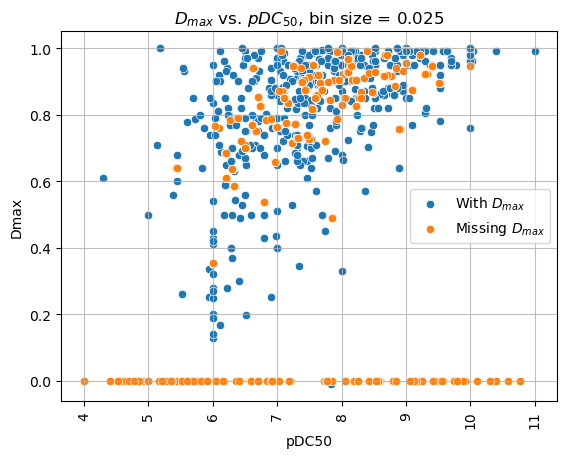

--------------------------------------------------------------------------------
bin size = 0.05
Min. num. of elements per bin: 1
Max. num. of elements per bin: 37
Avg. num. of elements per bin: 4.889
Num. of non-assigned Dmax values: 149 (20.50 %)


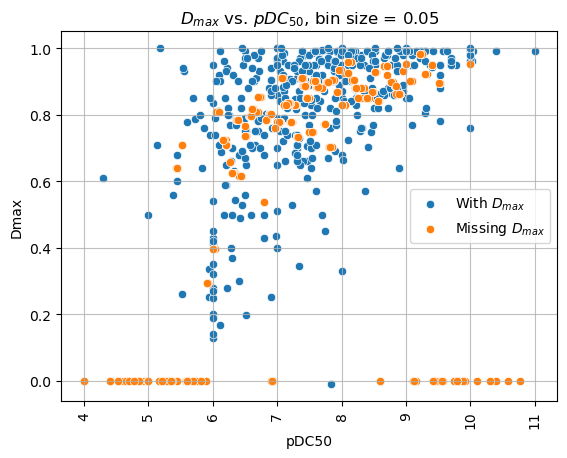

--------------------------------------------------------------------------------
bin size = 0.1
Min. num. of elements per bin: 1
Max. num. of elements per bin: 45
Avg. num. of elements per bin: 8.800
Num. of non-assigned Dmax values: 111 (15.27 %)


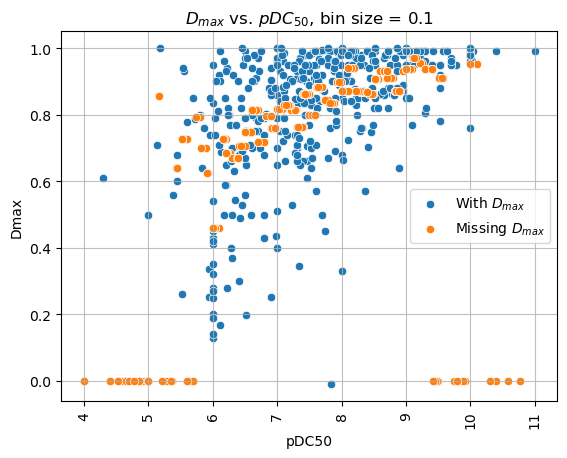

--------------------------------------------------------------------------------
bin size = 0.2
Min. num. of elements per bin: 1
Max. num. of elements per bin: 54
Avg. num. of elements per bin: 14.700
Num. of non-assigned Dmax values: 64 (8.80 %)


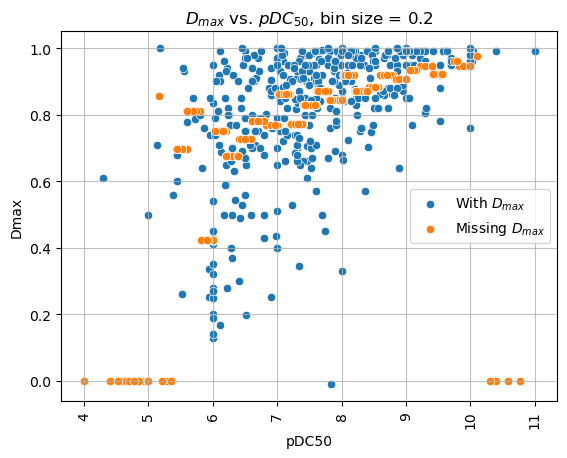

--------------------------------------------------------------------------------
bin size = 0.5
Min. num. of elements per bin: 1
Max. num. of elements per bin: 91
Avg. num. of elements per bin: 31.500
Num. of non-assigned Dmax values: 50 (6.88 %)


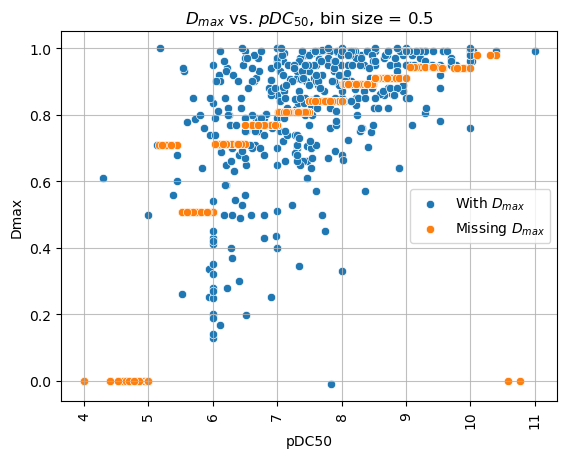

--------------------------------------------------------------------------------
bin size = 1
Min. num. of elements per bin: 2
Max. num. of elements per bin: 163
Avg. num. of elements per bin: 63.000
Num. of non-assigned Dmax values: 3 (0.41 %)


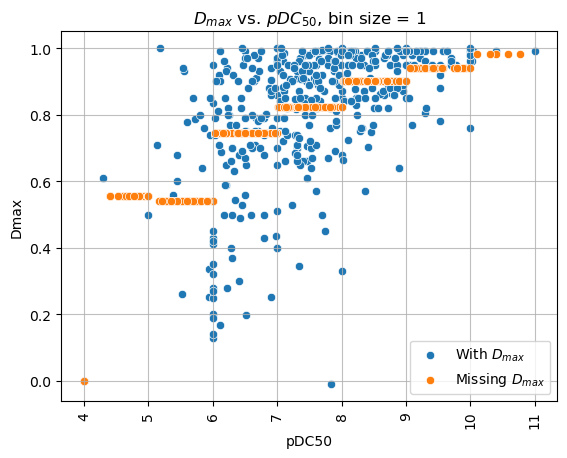

--------------------------------------------------------------------------------
bin size = 2
Min. num. of elements per bin: 4
Max. num. of elements per bin: 266
Avg. num. of elements per bin: 110.250
Num. of non-assigned Dmax values: 3 (0.41 %)


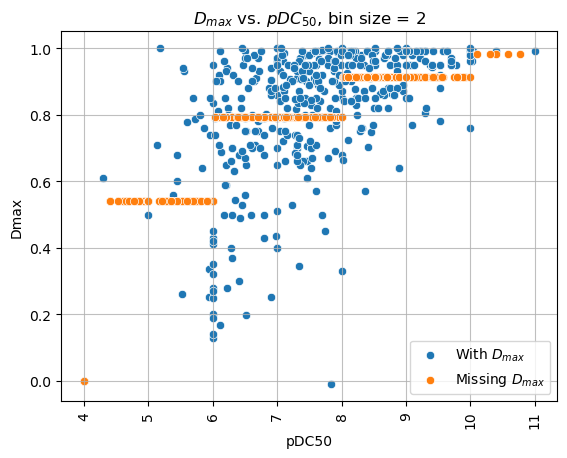

In [71]:
df = dataframes['active_inactive: rows with active/inactive']
A = df[df['pDC50'].notnull() & df['Dmax'].notnull()].copy()
B = dataframes['no_dmax: rows with empty Dmax but with DC50'].copy()

# Define bin sizes
bin_sizes = [0.025, 0.05, 0.1, 0.2, 0.5, 1, 2]
# Loop over bin sizes
for i, bin_size in enumerate(bin_sizes):
    print('-' * 80)
    print(f'bin size = {bin_size}')

    B['Dmax'] = float('nan')
    B['Dmax'] = get_avg_Dmax(A, B, bin_size, verbose=1)
    # Fill NaN values in B with a desired value (e.g., NaN to 0), just for
    # plotting purposes
    B['Dmax'] = B['Dmax'].fillna(0)

    _ = sns.scatterplot(data=df, x='pDC50', y='Dmax', label='With $D_{max}$')
    _ = sns.scatterplot(data=B, x='pDC50', y='Dmax', label='Missing $D_{max}$')
    plt.legend()
    plt.xticks(rotation=90)
    plt.grid(axis='both', alpha=0.8)
    plt.title('$D_{max}$ vs. $pDC_{50}$' + f', bin size = {bin_size}')
    plt.savefig(os.path.join(fig_dir, f'gif_{i}.png'), transparent = False, facecolor = 'white')
    plt.show()

In [72]:
# import imageio
# import os

# frames = []
# for i in range(7):
#     image = imageio.v2.imread(os.path.join(fig_dir, f'gif_{i}.png'))
#     frames.append(image)

# imageio.mimsave(os.path.join(fig_dir, 'gif.gif'), # output gif
#                 frames,         # optional: frames per second
#                 duration=1000)               # duration per frame

Since for higher $pDC_{50}$ values we have a narrower $D_{max}$ range, we can increase the bin size for higher $pDC_{50}$ values, _i.e._, after a threshold:

TODO: Using Optuna to find the best bin size and theshold value to minimize the number of non-assigned bins?

--------------------------------------------------------------------------------
pDC50 >= 8.0:
--------------------------------------------------------------------------------
Min. num. of elements per bin: 1
Max. num. of elements per bin: 124
Avg. num. of elements per bin: 48.889
Num. of non-assigned Dmax values: 1 (0.50 %)
--------------------------------------------------------------------------------
pDC50 < 8.0:
--------------------------------------------------------------------------------
Min. num. of elements per bin: 1
Max. num. of elements per bin: 54
Avg. num. of elements per bin: 14.700
Num. of non-assigned Dmax values: 60 (11.41 %)
--------------------------------------------------------------------------------
Final num. of assigned Dmax values: 666 (91.61 %)
Final num. of non-assigned Dmax values: 61 (8.39 %)


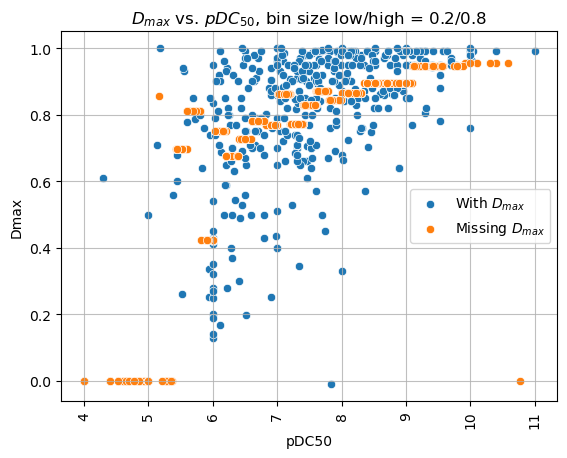

In [73]:
df = dataframes['active_inactive: rows with active/inactive']
A = df[df['pDC50'].notnull() & df['Dmax'].notnull()].copy()
B = dataframes['no_dmax: rows with empty Dmax but with DC50'].copy()

B['Dmax'] = float('nan')
pDC50_threshold = 8.0
B_high = B[B['pDC50'] >= pDC50_threshold]
B_low = B[B['pDC50'] < pDC50_threshold]
bin_size_low = 0.2
bin_size_high = 0.8

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print('-' * 80)
    print(f'pDC50 >= {pDC50_threshold}:')
    print('-' * 80)
    B_high['Dmax'] = get_avg_Dmax(A, B_high, bin_size=bin_size_high, verbose=1)
    print('-' * 80)
    print(f'pDC50 < {pDC50_threshold}:')
    print('-' * 80)
    B_low['Dmax'] = get_avg_Dmax(A, B_low, bin_size=bin_size_low, verbose=1)
B = pd.concat([B_high, B_low])
B['active'] = B[['Dmax', 'pDC50']].apply(lambda x: is_active(x['pDC50'], x['Dmax']), axis=1)
dataframes['avg_dmax: rows with avg. Dmax'] = B.copy()

num_nans = len(B[B['Dmax'].isnull()])
print('-' * 80)
print(f'Final num. of assigned Dmax values: {len(B) - num_nans} ({(len(B) - num_nans) / len(B) * 100:.2f} %)')
print(f'Final num. of non-assigned Dmax values: {num_nans} ({num_nans / len(B) * 100:.2f} %)')

# Fill NaN values in B with a desired value (e.g., NaN to 0), just for
# plotting purposes
B['Dmax'] = B['Dmax'].fillna(0)
_ = sns.scatterplot(data=A, x='pDC50', y='Dmax', label='With $D_{max}$')
_ = sns.scatterplot(data=B, x='pDC50', y='Dmax', label='Missing $D_{max}$')
plt.legend()
plt.xticks(rotation=90)
plt.grid(axis='both', alpha=0.8)
plt.title('$D_{max}$ vs. $pDC_{50}$' + f', bin size low/high = {bin_size_low}/{bin_size_high}')
plt.show()


## Curve Fitting

* We can use the curve fitting of/for IC50 for estimating the concentration at $D_{max}$
* For a regression task, we would then need to predict the $D_{max}$ together with the concentration **at $D_{max}$** instead of the $pDC_{50}$
* We assume no hook effect. Especially since we have no enough information for fitting the curves ourselves

Inspired from [this blogpost](https://towardsdatascience.com/drug-dose-response-data-analysis-5d7d336ad8e9).

In [74]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def hill_equation(x, E0, Einf, EC50, Hill_slope):
    """
    Hill equation function.
    x: independent variable (dose)
    a, b, c, d: parameters of the equation
    """
    return E0 + (Einf - E0) / (1 + np.exp(Hill_slope * (np.log(x) - np.log(EC50))))
    # return a + (b - a) / (1 + np.exp(d * (np.log(x) - np.log(c))))

def interpolate_dose_response(doses, responses, run_interpolation=False, num_interpolation_points=100):
    """
    Interpolates the points in a dose-response curve using the Hill equation.

    Parameters:
        doses (list or array): List of dose values.
        responses (list or array): List of response values corresponding to the doses.

    Returns:
        interpolated_doses (array): Array of interpolated dose values.
        interpolated_responses (array): Array of interpolated response values.

    Hill Equation:
        The Hill equation is used to model dose-response curves. It is defined as:
        f(x) = a + (b - a) / (1 + (x / c) ** d)

        where:
        - x: independent variable (dose)
        - a: lower asymptote or response value at low doses
        - b: upper asymptote or response value at high doses
        - c: dose at which the response is halfway between a and b (EC50)
        - d: Hill slope or the steepness of the curve.

    Interpolation:
        The function fits the Hill equation to the given dose-response data using
        curve fitting and then generates interpolated points along the curve.

    Example Usage:
        doses = [1, 2, 3, 4, 5]
        responses = [0.1, 0.4, 0.7, 0.9, 1.0]
        interpolated_doses, interpolated_responses = interpolate_dose_response(doses, responses)
    """

    # Fit the Hill equation to the data
    initial_guess = [np.min(responses), np.max(responses), np.median(doses), 1.0]
    params, _ = curve_fit(hill_equation, doses, responses, p0=initial_guess,
                          bounds=(0, 100))
    # Generate interpolated points
    interpolated_doses = np.linspace(min(doses), max(doses), num=len(doses) * num_interpolation_points)
    curve_points = ['D0', 'Dmax', 'pDC50', 'Hill']
    ret = {c: p for c, p in zip(curve_points, params)}
    if run_interpolation:
        interpolated_responses = hill_equation(interpolated_doses, *params)
        return ret, interpolated_doses, interpolated_responses
    else:
        return ret

Ignore values after hook effect happening:

TODO: How to deal with hook effect? For now, we just ignore the values after the hook effect happens.

In [75]:
def remove_hook_effect(concentrations, degradations, threshold=0.1, sorted=False):
    """Remove points after hook effect, if detected.
    
    NOTE: Each concentration value is associated to the corresponding degradation value at the same index.
    If the concentrations are not sorted, then the function can sorte them.

    Args:
        concentrations (iterable): List of concentration values in -Log10 units.
        degradations (iterable): List of degradation response values in percentage.
        threshold (float, optional): If the next degradation value is higher than the previous one by a threshold percentage, then it is considered hook effect. Defaults to 0.1.

    Returns:
        Tuple: concentrations_nohook, degradations_nohook, hook_effect_happened
    """
    assert 0 <= threshold <= 1, f'Threshold must be between 0 and 1. Got instead: {threshold}'
    assert len(concentrations) == len(degradations)
    if not sorted:
        # Sort according to the concentrations, so that they are in descending
        # order. Without hook effect, the lower the concentration, the higher
        # the degradation will become.
        concentrations = np.array(concentrations)
        degradations = np.array(degradations)
        sorted_idx = list(reversed(np.argsort(concentrations)))
        concentrations = concentrations[sorted_idx]
        degradations = degradations[sorted_idx]
    max_degradation = min(degradations)
    concentrations_nohook, degradations_nohook = [], []
    hook_effect_happened = False
    for conc, degr in zip(concentrations, degradations):
        assert degr >= 0 and conc >= 0, f'Concentrations and degradations must be positive. Got instead: {conc} nM, {degr} %'
        if degr >= max_degradation:
            concentrations_nohook.append(conc)
            degradations_nohook.append(degr)
            max_degradation = degr
        else:
            if 1.0 - degr / max_degradation < threshold:
                concentrations_nohook.append(conc)
                degradations_nohook.append(degr)
                max_degradation = degr
            else:
                hook_effect_happened = True
                break
    return concentrations_nohook, degradations_nohook, hook_effect_happened

print('I should get the same lists:', remove_hook_effect([9.0, 8.0, 7.0, 6.0], [49.0, 84.0, 89.0, 97.0]))
print('Less strict threshold on hook effect definition:', remove_hook_effect([9.0, 8.0, 7.0, 6.0], [42.0, 76.0, 75.0, 21.0]))
print('Anything "decreasing" is removed:', remove_hook_effect([9.0, 8.0, 7.0, 6.0], [42.0, 76.0, 75.0, 21.0], threshold=0))

I should get the same lists: ([9.0, 8.0, 7.0, 6.0], [49.0, 84.0, 89.0, 97.0], False)
Less strict threshold on hook effect definition: ([9.0, 8.0, 7.0], [42.0, 76.0, 75.0], True)
Anything "decreasing" is removed: ([9.0, 8.0], [42.0, 76.0], True)


Interpolate function:

In [76]:
from sklearn.linear_model import LinearRegression

def interpolate_pDC50_Dmax(assay_descr, degradation_descr,
                           plot_curve: bool = False,
                           lin_approx_rmsd_threshold: float = 3.0,
                           steepness_threshold: float = 0.25):
    """
    Interpolates the pDC50 and Dmax values from the assay and degradation descriptions.

    Parameters:
        assay_descr (str): Description of the assay.
        degradation_descr (str): Description of the degradation.

    Returns:
        pDC50 (float): Interpolated pDC50 value.
        Dmax (float): Interpolated Dmax value.
    """
    # Parse assay description
    assay = assay_descr.split('at')[-1]
    doses = split_clean_str(re.sub('[^0-9\./]', '', assay), return_floats=True)
    doses = [-np.log10(d * 1e-9) for d in doses]
    # Parse degradation description
    degradations = split_clean_str(degradation_descr, return_floats=True)
    # Remove hook effect
    assert len(doses) == len(degradations)
    doses, degradations, hook_effect_happened = remove_hook_effect(doses, degradations)
    # Interpolate dose-response curve
    default_params = params = {
        'D0': float('nan'),
        'Dmax': float('nan'),
        'pDC50': float('nan'),
        'Hill': float('nan'),
        'hook_effect': hook_effect_happened,
    }
    if len(doses) > 2:
        try:
            params = interpolate_dose_response(doses, degradations)
        except RuntimeError:
            print(f"WARNING: Curve fitting numerically failed. See SciPy documentation on `curve_fit` function.")
            return default_params
        params['hook_effect'] = hook_effect_happened
        # Check if RMSE of the interpolated curve compared to a linear fit is
        # less than a threshold value
        x_test = np.linspace(min(doses), max(doses), num=len(doses) * 100)
        # Get linear fit
        model = LinearRegression()
        model.fit(np.array(doses).reshape(-1, 1), np.array(degradations).reshape(-1, 1))
        y_lin = model.predict(x_test.reshape(-1, 1)).flatten()
        # Interpolate new points with the Hill equation defined by the
        # parameters just found
        y_hill = hill_equation(x_test,
                               E0=params['D0'],
                               Einf=params['Dmax'],
                               EC50=params['pDC50'],
                               Hill_slope=params['Hill'])
        # Calculate RMSD
        lin_points = np.array([x_test, y_lin]).T
        hill_points = np.array([x_test, y_hill]).T
        rmsd = np.sqrt(np.mean((lin_points - hill_points) ** 2))
        # If RMSD is less than a threshold, then the Hill equation is not a
        # good fit and the entry is discarded
        if rmsd < lin_approx_rmsd_threshold:
            print(f"WARNING: Hill function too close to a line curve, RMSD: {rmsd:.3f}.")
            params = default_params
        # Check if the curve is "too steep", i.e., w/out a "turning point"
        if min(doses) - steepness_threshold < params['pDC50'] < min(doses) + steepness_threshold:
            print(f"WARNING: Interpolated pDC50 is too close to the minimum dose value (interpolated/min: {params['pDC50']:.3f} / {min(doses):.3f}).")
            params = default_params
        if max(doses) - steepness_threshold < params['pDC50'] < max(doses) + steepness_threshold:
            print(f"WARNING: Interpolated pDC50 is too close to the maximum dose value (interpolated/max: {params['pDC50']:.3f} / {max(doses):.3f}).")
            params = default_params
        if plot_curve:
            # Plot original data and interpolated curve
            plt.scatter(doses, degradations, label='Original Data')
            plt.plot(x_test, y_hill, label='Hill func. Interpolation')
            plt.plot(x_test, y_lin, label='Linear Interpolation')
            plt.grid(alpha=0.7)
            plt.xlabel('$pDC_{50}$ (-Log10 units)')
            plt.ylabel('$D_{max}$ (%)')
            plt.gca().invert_xaxis()
            plt.gca().invert_yaxis()
            plt.legend()
            plt.show()
    return params

Examples:

Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------


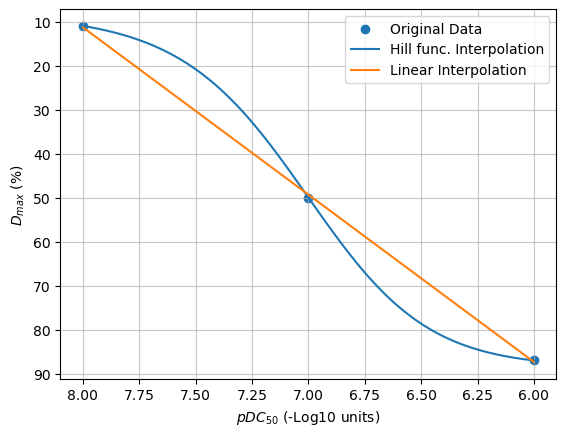

Interpolated pDC50: 7.02 (-Log10 units)
Interpolated Dmax: 88.42 (%)
--------------------------------------------------------------------------------


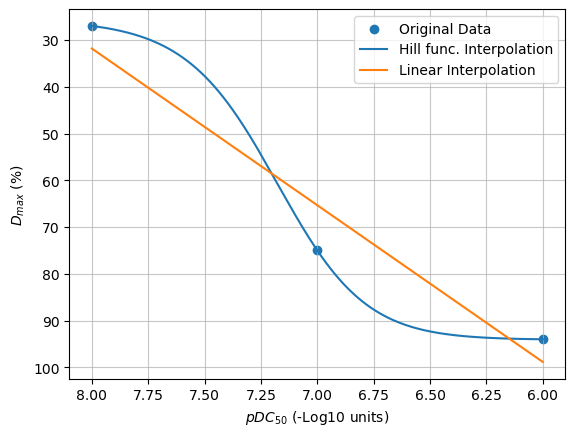

Interpolated pDC50: 7.19 (-Log10 units)
Interpolated Dmax: 94.10 (%)
--------------------------------------------------------------------------------


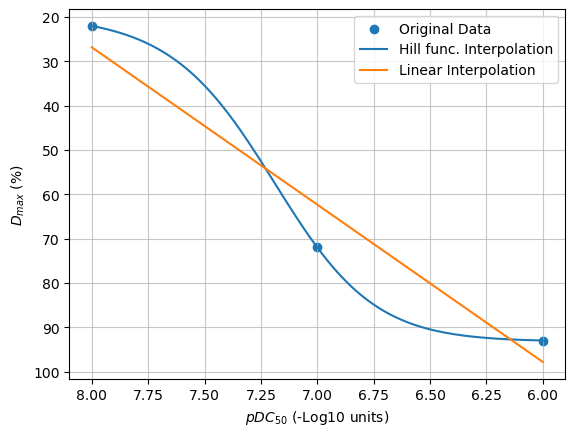

Interpolated pDC50: 7.20 (-Log10 units)
Interpolated Dmax: 93.22 (%)
--------------------------------------------------------------------------------


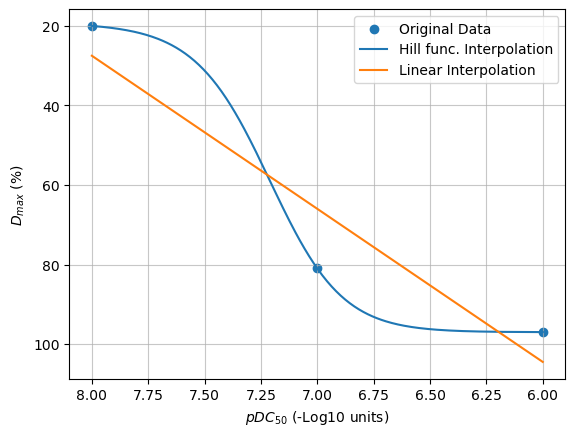

Interpolated pDC50: 7.22 (-Log10 units)
Interpolated Dmax: 97.02 (%)
--------------------------------------------------------------------------------


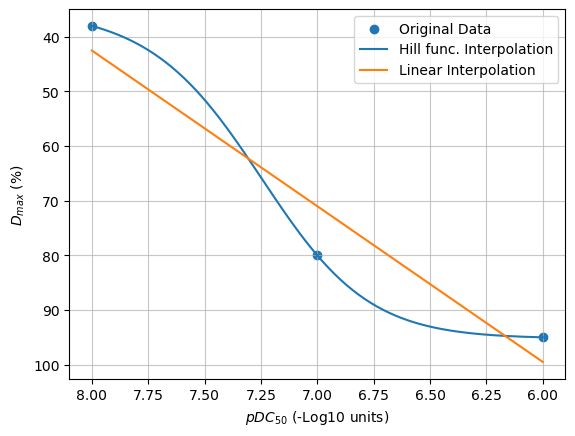

Interpolated pDC50: 7.26 (-Log10 units)
Interpolated Dmax: 95.21 (%)
--------------------------------------------------------------------------------


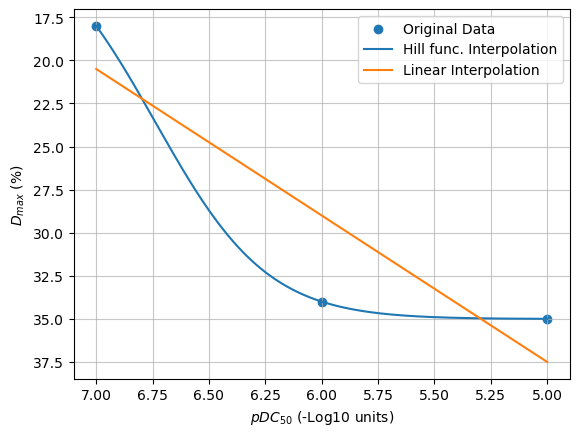

Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------


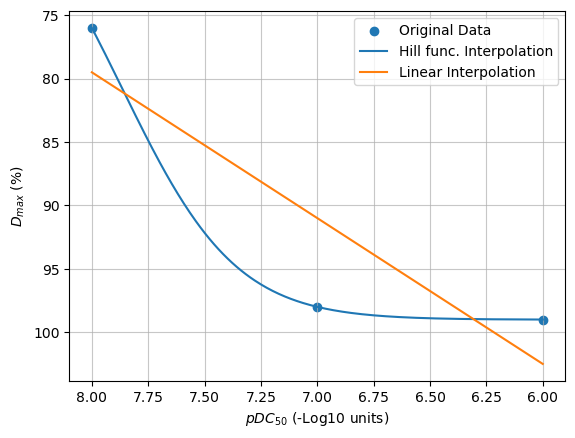

Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------


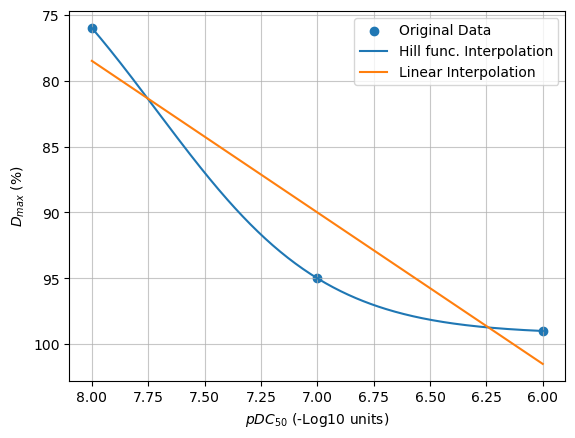

Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------
Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------
Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------
Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------


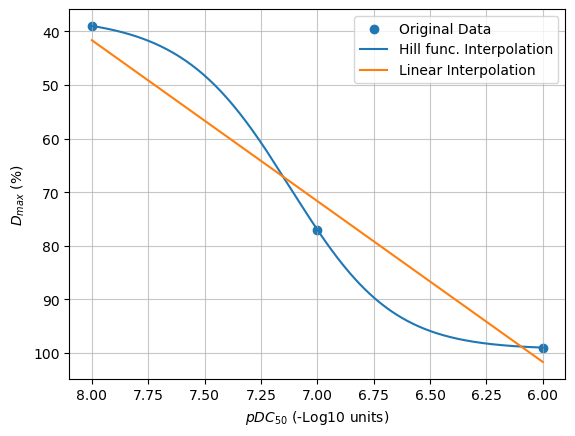

Interpolated pDC50: 7.13 (-Log10 units)
Interpolated Dmax: 99.31 (%)
--------------------------------------------------------------------------------


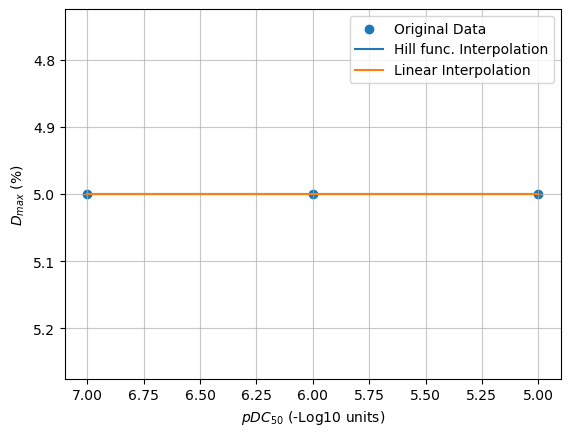

Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------


In [77]:
for i in range(17, 31):
    row = dataframes[f'perc_degr_assay: rows with "Assay (Percent degradation)"'].iloc[i]
    assay_descr = row['Assay (Percent degradation)'].split('at')[-1]
    degradation_descr = row['Percent degradation (%)']
    params = interpolate_pDC50_Dmax(assay_descr, degradation_descr, plot_curve=True)

    print(f'Interpolated pDC50: {params["pDC50"]:.2f} (-Log10 units)')
    print(f'Interpolated Dmax: {params["Dmax"]:.2f} (%)')
    print('-' * 80)

Wrapper function for interpolating and cleaning entries:

In [78]:
def clean_perc_degr_entries(row):
    assay_descr = row['Assay (Percent degradation)'].split('at')[-1]
    degradation_descr = row['Percent degradation (%)']
    params = interpolate_pDC50_Dmax(assay_descr, degradation_descr)
    row['DC50'] = 10**(-params['pDC50']) # Expressed in M
    row['pDC50'] = params['pDC50']
    row['Dmax'] = params['Dmax'] / 100.0
    row['hook_effect'] = params['hook_effect']
    row['active'] = True if (row['pDC50'] >= 7.0) and (row['Dmax'] >= 0.8) else False
    row['hook_effect'] = params['hook_effect']
    # Get cell type
    cell_type = row['Assay (Percent degradation)'].split('in')[-1]
    cell_type = cell_type.split('cells')[0].strip()
    row['cell_type'] = cell_type
    # Get POI gene ID
    gene_id = row['Assay (Percent degradation)'].split('% ')[-1]
    gene_id = gene_id.split('degradation')[0].strip()
    row['poi_gene_id_parsed'] = gene_id
    # Apply mutation to POI sequence
    row['poi_sequence'] = apply_mutation(row['Uniprot'], row['poi_gene_id'], row['poi_seq'], on_error='ignore')
    # Get treatment hours
    if 'treatment' in row['Assay (Percent degradation)']:
        treatment_hours = row['Assay (Percent degradation)'].split('after')[-1]
        treatment_hours = treatment_hours.split('h treatment')[0].strip()
    else:
        treatment_hours = float('nan')
    row['treatment_hours'] = treatment_hours
    return row

Clean entries with "Assay (Percent degradation)":

TODO: There are some entries with RMSD == 0, so some points on a stright line. How to deal with them?

In [79]:
df = dataframes[f'perc_degr_assay: rows with "Assay (Percent degradation)"']
interpolated_df = df.apply(clean_perc_degr_entries, axis=1)
tmp = interpolated_df.dropna(subset=['pDC50', 'Dmax', 'hook_effect'])
cols_to_show = [
    'Assay (Percent degradation)',
    'poi_gene_id_parsed',
    'cell_type',
    'treatment_hours',
    'pDC50',
    'Dmax',
    'active',
    'hook_effect',
]
display(tmp[cols_to_show].head())
print('-' * 80)
print(f'Number of entries with interpolated pDC50 and Dmax: {len(tmp)}')
print(f'Percentage of entries with successfully interpolated pDC50 and Dmax: {len(tmp) / len(df) * 100:.2f}%')
dataframes[f'interpolated_dc50: rows with interpolated percent degradation'] = interpolated_df

Operation: L858R on ...HVKITDFG[R -> R]AKLLGAE...
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation is applied.
Operation: L858R on ...HVKITDFG[R -> R]AKLLGAE...
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation is applied.
Operation: L858R on ...HVKITDFG[R -> R]AKLLGAE...
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation is applied.
Operation: L858R on ...HVKITDFG[R -> R]AKLLGAE...
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation is applied.
Operation: L858R on ...HVKITDFG[R -> R]AKLLGAE...
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation is applied.
Operation: L858R on ...HVKITDFG[R -> R]AKLLGAE...
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation is applied.
Operation: L858R on ...HVKITDFG[R -> R]AKLLGAE...
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutati

,Assay (Percent degradation),poi_gene_id_parsed,cell_type,treatment_hours,pDC50,Dmax,active,hook_effect
134,% AR degradation in LNCaP cells after 6 h trea...,AR,LNCaP,6,6.867694,0.662907,False,False
135,% AR degradation in LNCaP cells after 6 h trea...,AR,LNCaP,6,7.156387,0.870556,True,False
136,% AR degradation in LNCaP cells after 6 h trea...,AR,LNCaP,6,7.000827,0.927833,True,False
137,% AR degradation in LNCaP cells after 6 h trea...,AR,LNCaP,6,7.008338,0.897034,True,False
138,% AR degradation in LNCaP cells after 6 h trea...,AR,LNCaP,6,6.258717,0.750021,False,False


--------------------------------------------------------------------------------
Number of entries with interpolated pDC50 and Dmax: 56
Percentage of entries with successfully interpolated pDC50 and Dmax: 15.47%


## Assemble SSL Dataframe

Add all entries with `active` column set to `NaN` to the SSL dataframe:

In [80]:
dataframes['ssl: SSL dataframe'] = pd.DataFrame()

print(f'Extracting entries with missing active/inactive:')
for k, v in dataframes.items():
    if 'rows with active/inactive' in k or 'ssl: SSL dataframe' in k:
        continue
    print(f'From dataframe: "{k}"...')
    if 'active' not in v.columns:
        no_activity_df = v
    else:
        no_activity_df = v[v['active'].isnull()]
    dataframes['ssl: SSL dataframe'] = pd.concat([dataframes['ssl: SSL dataframe'], no_activity_df], axis=0, ignore_index=True)
dataframes['ssl: SSL dataframe'] = dataframes['ssl: SSL dataframe'].drop_duplicates()
print('-' * 80)
print(f'Number of entries with no activity: {len(dataframes["ssl: SSL dataframe"])}')
dataframes['ssl: SSL dataframe'][dataframes['ssl: SSL dataframe']['active'].isnull()]

Extracting entries with missing active/inactive:
From dataframe: "non_degrading: rows with no degradation"...
From dataframe: "no_assay_info: rows with no assay info"...
From dataframe: "perc_degr_assay: rows with "Assay (Percent degradation)""...
From dataframe: "dc50_dmax_assay: rows with "Assay (DC50/Dmax)""...
From dataframe: "no_dmax: rows with empty Dmax but with DC50"...
From dataframe: "no_dc50: rows with empty DC50 but with Dmax"...


C:\Users\ste\AppData\Local\Temp\ipykernel_17348\2557429318.py:12: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  dataframes['ssl: SSL dataframe'] = pd.concat([dataframes['ssl: SSL dataframe'], no_activity_df], axis=0, ignore_index=True)


From dataframe: "avg_dmax: rows with avg. Dmax"...
From dataframe: "interpolated_dc50: rows with interpolated percent degradation"...
--------------------------------------------------------------------------------
Number of entries with no activity: 4545


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,cell_type,treatment_hours,active,hook_effect,DC50,pDC50,Dmax,poi_gene_id_parsed,hook_effectpoi_gene_id_parsed,poi_sequence
0,1,Q9NPI1,BRD7,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Q9H8M2,BRD9,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Q9NPI1,BRD7,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,Q9H8M2,BRD9,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Q9H8M2,BRD9,CRBN,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4548,3221,Q07817,BCL-xL,VHL,NaN,753b,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,6,NaN,Degradation of BCL-xL in 293T cells after 16 h...,...,293T,16,NaN,NaN,0.0,8.221849,NaN,BCL-XL,NaN,NaN
4549,3256,P10636,Tau,VHL,NaN,C004019,CC(=O)N1CCCN(c2nc(NCCc3cccs3)nc(N(C)CC(=O)NCCO...,7.85,NaN,Degradation of Tau5 in HEK293-hTau cells after...,...,HEK293,24,NaN,NaN,0.0,8.10513,NaN,TAU5,NaN,NaN
4550,3256,P10636,Tau,VHL,NaN,C004019,CC(=O)N1CCCN(c2nc(NCCc3cccs3)nc(N(C)CC(=O)NCCO...,7.85,NaN,Degradation of Tau5 in HEK293-hTau cells after...,...,HEK293,24,NaN,NaN,0.0,8.10513,NaN,HTAU,NaN,NaN
4551,3269,P03372,ER,CRBN,NaN,ARV-471,O=C1CC[C@H](N2Cc3cc(N4CCN(CC5CCN(c6ccc([C@@H]7...,2,NaN,Degradation of ER in ER-positive breast cancer...,...,Unknown,Unknown,NaN,NaN,0.0,8.69897,NaN,ER,NaN,NaN


TODO: Double check that entries in the active/inactive dataframe are **NOT** present in the SSL dataframe.

In [81]:
# TODO
dataframes['ssl: SSL dataframe'] = dataframes['ssl: SSL dataframe'][~dataframes['ssl: SSL dataframe'].isin(dataframes['active_inactive: rows with active/inactive'])]
dataframes['ssl: SSL dataframe']

,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,cell_type,treatment_hours,active,hook_effect,DC50,pDC50,Dmax,poi_gene_id_parsed,hook_effectpoi_gene_id_parsed,poi_sequence
0,1,Q9NPI1,BRD7,NaN,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,Q9H8M2,BRD9,NaN,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Q9H8M2,BRD9,CRBN,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4548,3221,Q07817,BCL-xL,VHL,NaN,753b,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,6,NaN,Degradation of BCL-xL in 293T cells after 16 h...,...,293T,16,NaN,NaN,0.0,8.221849,NaN,BCL-XL,NaN,NaN
4549,3256,P10636,Tau,VHL,NaN,C004019,CC(=O)N1CCCN(c2nc(NCCc3cccs3)nc(N(C)CC(=O)NCCO...,7.85,NaN,Degradation of Tau5 in HEK293-hTau cells after...,...,HEK293,24,NaN,NaN,0.0,8.10513,NaN,TAU5,NaN,NaN
4550,3256,P10636,Tau,VHL,NaN,C004019,CC(=O)N1CCCN(c2nc(NCCc3cccs3)nc(N(C)CC(=O)NCCO...,7.85,NaN,Degradation of Tau5 in HEK293-hTau cells after...,...,HEK293,24,NaN,NaN,0.0,8.10513,NaN,HTAU,NaN,NaN
4551,3269,P03372,ER,CRBN,NaN,ARV-471,O=C1CC[C@H](N2Cc3cc(N4CCN(CC5CCN(c6ccc([C@@H]7...,2,NaN,Degradation of ER in ER-positive breast cancer...,...,Unknown,Unknown,NaN,NaN,0.0,8.69897,NaN,ER,NaN,NaN


## Save Cleaned DataFrames to File

Save and check if dataframes include the columns relevant for the machine learning models:

In [82]:
dataframes['perc_degr_assay: rows with "Assay (Percent degradation)"']['Dmax'] = float('nan')

C:\Users\ste\AppData\Local\Temp\ipykernel_17348\330910889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['perc_degr_assay: rows with "Assay (Percent degradation)"']['Dmax'] = float('nan')


In [83]:
columns_to_check = [
    'Smiles',
    'Smiles_nostereo',
    'DC50',
    'pDC50',
    'Dmax',
    'poi_gene_id',
    'poi_seq',
    'cell_type',
    'treatment_hours',
    'e3_ligase',
    'active',
]
for k, v in dataframes.items():
    print(f'"{k}": {len(v)}')
    df_id = k.split(':')[0].strip()
    csv_name = f'protac_db_{df_id}.csv'
    filename = os.path.join(data_dir, 'processed', csv_name)
    v.to_csv(filename, index=False)
    # Check if all columns are present
    cols = pd.read_csv(filename).reset_index(drop=True).columns
    for c in columns_to_check:
        if c not in cols:
            print(f'\tERROR. Column {c} not found in: {csv_name}')

"non_degrading: rows with no degradation": 339
"no_assay_info: rows with no assay info": 3737
"perc_degr_assay: rows with "Assay (Percent degradation)"": 362
"dc50_dmax_assay: rows with "Assay (DC50/Dmax)"": 1276
"no_dmax: rows with empty Dmax but with DC50": 727
"no_dc50: rows with empty DC50 but with Dmax": 86
"active_inactive: rows with active/inactive": 822
"avg_dmax: rows with avg. Dmax": 727
"interpolated_dc50: rows with interpolated percent degradation": 362
"ssl: SSL dataframe": 4545


# Legacy Deprecated Code

## DEPRECATED: Parse and Split Rows

Define a function to extract the $pDC_{50}$ and $D_{max}$ values from the assay description corresponding to _'Assay (DC50/Dmax)'_.

Notes:

* The $DC_{50}$ values are expected to be in nM
* The $D_{max}$ values are normalized between 0 and 1

In [ ]:
def parse_and_check_assay(assay, col_with_slashes, stats=None, weird_entries=None, row=None):
    """"""
    parsed_assay = parse_assay_text(assay)
    parsed_assay['mismatch_len_error'] = False
    if pd.notnull(col_with_slashes):
        splitted_info = split_clean_str(col_with_slashes)
        if len(splitted_info) > 1:
            if len(splitted_info) == len(parsed_assay['cells']):
                pass
            elif len(splitted_info) == len(parsed_assay['genes']):
                pass
            elif len(splitted_info) == len(parsed_assay['treatment_hours']):
                pass
            elif len(splitted_info) == len(parsed_assay['concentrations']):
                pass
            else:
                print(f'WARNING. Degradations "{splitted_info}" do not match the parsed information.')
                print(f'\t* Assay: "{assay}".')
                print(f'\t* Parsed info: {parsed_assay}')
                print('')
                parsed_assay['mismatch_len_error'] = True
                if stats is not None and weird_entries is not None and row is not None:
                    update_stats(stats, 'rows with mismatching slashes')
                    weird_entries['rows with mismatching slashes'].append(row)
    else:
        splitted_info = None
    return parsed_assay, splitted_info

def is_DC50_col_empty(i, protac_df=protac_df):
    return pd.isnull(protac_df.iloc[i]['DC50 (nM)'])    

def is_Dmax_col_empty(i, protac_df=protac_df):
    return pd.isnull(protac_df.iloc[i]['Dmax (%)'])

def extract_from_DC50_Dmax_assay(i, row, stats=None, weird_entries=None, verbose=0):
    def update_statistics(stat_descr):
        if stats is not None and weird_entries is not None:
            update_stats(stats, stat_descr)
            weird_entries[stat_descr].append(row)
    assay = row['Assay (DC50/Dmax)']
    DC50_col = row['DC50 (nM)']
    Dmax_col = row['Dmax (%)']
    parsed_assay, DC50_values = parse_and_check_assay(assay, DC50_col, stats, weird_entries, row)
    if parsed_assay['mismatch_len_error']:
        update_statistics('Mismatched parsed lengths in DC50/Dmax assay')
        return None # Go to next row of PROTAC-DB
    
    if not is_DC50_col_empty(i):
        DC50_values = split_clean_str(DC50_col)
        # "Slashed" entries correspond to DC50/Dmax pairs obtained from
        # assays on different cell lines. We then need to split the
        # entry into multiple rows to be added to the cleaned database.
        if not is_Dmax_col_empty(i):
            Dmax_values = split_clean_str(Dmax_col)
            concentrations = []
            degradations = []

            for DC50, Dmax in zip(DC50_values, Dmax_values):                
                DC50 = float(DC50)
                Dmax = float(Dmax) / 100
                
                if np.isnan(Dmax) or np.isinf(Dmax):
                    # Not available Dmax entry, skip "slashed" entry
                    continue
                if np.isnan(DC50) or np.isinf(DC50):
                    # Not available DC50 entry, skip "slashed" entry
                    continue
                # if Dmax == np.inf:
                #     Dmax = 'NaN'
                # if DC50 == np.inf:
                #     DC50 = 'NaN'

                degradations.append(f'{Dmax}')
                concentrations.append(f'{DC50}')
                
                # # TODO: Shall I add the following data point, i.e., the
                # # estimated concentration at Dmax?
                # degradations.append(f'{Dmax * 100}') # Back to 100 scale
                # concentrations.append(f'{DC50 / 0.5}')
            ret = {
                'Dmax': degradations, 
                'DC50': concentrations, 
                'parsed_assay': parsed_assay,
                }
            return ret
        else:
            update_statistics('rows with empty Dmax but with DC50')    
            if verbose > 0:
                print(f'WARNING. Entry with no Dmax but with DC50:')
                print(f'\t* Assay: "{row["Assay (DC50/Dmax)"]}"')
                print(f'\t* DC50 (nM): {row["DC50 (nM)"]}')
                print(f'\t* Dmax (%): {row["Dmax (%)"]}')
                print(f'\t* Row: {row}')
                print('')
            return None # Go to next row of PROTAC-DB
    elif not is_Dmax_col_empty(i):
        Dmax_values = split_clean_str(Dmax_col)
        
        update_statistics('rows with empty DC50 but with Dmax')
        if verbose > 0:
            print(f'WARNING. Entry with no DC50 but with Dmax:')
            print(f'\t* Assay: "{row["Assay (DC50/Dmax)"]}"')
            print(f'\t* DC50 (nM): {row["DC50 (nM)"]}')
            print(f'\t* Dmax (%): {row["Dmax (%)"]}')
            print(f'\t* Row: {row}')
            print('')
        return None # Go to next row of PROTAC-DB
    else:
        # TODO: Both the DC50 and the Dmax are missing
        stat_descr = 'rows with empty DC50 and empty Dmax (but with non-empty assay)'
        update_statistics(stat_descr)
        if verbose > 0:
            print(f'WARNING. empty DC50 and empty Dmax despite the non-empty assay:')
            print(f'\t* Assay: "{row["Assay (DC50/Dmax)"]}"')
            print(f'\t* DC50 (nM): {row["DC50 (nM)"]}')
            print(f'\t* Dmax (%): {row["Dmax (%)"]}')
            print(f'\t* Row: {row}')
            print('')
        return None # Go to next row of PROTAC-DB

Define a function to extract the $pDC_{50}$ and $D_{max}$ values from the assay description corresponding to _'Assay (Percent degradation)'_.

DEPRECATED: See the "Curve Fitting" section below instead. 

In [ ]:
def extract_from_Perc_Degr_assay(row, stats=None, weird_entries=None):
    # Example: 10/100/1000 nM -> 23.5/45.9/7.1 %
    # TODO: Work in progress, skip these entries for now
    # TODO: DC50 and Dmax can be extrapolated when there are 3 or more
    # "slashed" entries, i.e. at the same row.
    # TODO: When less then 3 "slashed" entries, keep the highest one, the
    # highest perc value will be Dmax (even when hook effect shows up)
    assay = row['Assay (Percent degradation)']
    Degr_col = row['Percent degradation (%)']
    parsed_assay = parse_and_check_assay(row, assay, Degr_col, stats, weird_entries)
    if parsed_assay['mismatch_len_error']:
        stat_descr = 'Mismatched parsed lengths in perc.degr. assay'
        update_stats(stats, stat_descr)
        weird_entries[stat_descr].append(row)
        return None # Go to next row of PROTAC-DB
    degradations = split_clean_str(Degr_col)
    concentrations = [clean_string(s) for s in parsed_assay['concentrations']]
    
    for j in range(1, len(degradations) - 1):
        if degradations[j - 1] > degradations[j]:
            stat_descr = 'rows with (possibly) hook effect'
            update_stats(stats, stat_descr)
            weird_entries[stat_descr].append(row)
            break

    for j in range(1, 5):
        if len(concentrations) == j:
            stat_descr = f'rows with "Assay (Percent degradation)" and n.{j} points on the dose-response curve'
            update_stats(stats, stat_descr)
            weird_entries[stat_descr].append(row)
            break
    # ==========================================================================
    # Possibly checking for hook effect
    # ==========================================================================
    # rows_to_add = []
    # for j, resp in enumerate(Dmax):
    #     # Convert to float degradation and concentration string lists
    #     row['Dmax'] = float(resp)
    #     row['DC50'] = float(DC50[j % len(DC50)])
    #     # Check for hook effect
    #     if j > 0:
    #         d_prev = float(Dmax[(j - 1) % len(Dmax)])
    #         d_curr = float(Dmax[j % len(Dmax)])
    #         c_prev = float(DC50[(j - 1) % len(DC50)])
    #         c_curr = float(DC50[j % len(DC50)])
    #         if c_curr > c_prev and d_curr < d_prev:
    #             print(f'WARNING. Degradations {Dmax} might show a "hook effect".')
    #             print(f'\t* Percent degradation (%): {row["Percent degradation (%)"]}')
    #             print(f'\t* Parsed info: {parsed_assay}')
    #             print('')
    #     # Add extra information from the parsed assay description
    #     genes = parsed_assay['genes']
    #     cells = parsed_assay['cells']
    #     treatment_hours = parsed_assay['treatment_hours']
    #     row['poi_gene_id_parsed'] = genes[j % len(genes)]
    #     row['cell_type'] = cells[j % len(cells)]
    #     row['treatment_hours'] = treatment_hours[j % len(treatment_hours)]
    #     rows_to_add.append(row.copy())
    
    
    return None # Go to next row of PROTAC-DB

Loop over each row, _i.e._, entry, in the PROTAC-DB and extract the degradation percentages and concentrations.


* NOTE: Multitask learning: it might be useful for dealing
with those entries which miss either DC50 or Dmax. Maybe
trining on one of them, and then "combine" the two networks?
* NOTE: The tasks will only be two then: binary
classification following the DeepPROTAC paper approach
(helpful for eventually compare the approaches), and
predicting the PAIR pDC50 and Dmax (I cannot predict only
one of them, they must go together)
* TODO: Only focus on those entries with BOTH values DC50
and Dmax available, we'll take care of the other entries
later on.

In [ ]:
# NOTE: Since the defaultdict will create a new list if the key is not found in
# the dictionary, this will have unintented side-effects. For example, if you
# simply want to retrieve a value for the key, which is not there, it will
# create a new list and return it.
weird_entries = defaultdict(list)
stats = {}

if not parsed_df_loaded:
    total_len = len(protac_df)    
    parsed_tables = defaultdict(list)
    parsed_table = []
    # ==========================================================================
    # Loop over each row of the PROTAC-DB
    # ==========================================================================
    for i, row in enumerate(protac_df.to_dict(orient='records')):
        # Add default values for the parsed assay description
        row['active'] = float('nan')
        row['Dmax'] = float('nan')
        row['DC50'] = float('nan')
        row['poi_gene_id_parsed'] = float('nan')
        row['cell_type'] = float('nan')
        row['treatment_hours'] = float('nan')

        if not pd.isnull(row['Assay (DC50/Dmax)']):
            parsed_info = extract_from_DC50_Dmax_assay(i, row, stats, weird_entries)
        elif not pd.isnull(row['Assay (Percent degradation)']):
        # elif row['Assay (Percent degradation)'].notnull():
            # TODO: Work in progress, skip these entries for now
            parsed_info = extract_from_Perc_Degr_assay(row, stats, weird_entries)
        else:
            # No Assay description: collect stats and continue
            if is_DC50_col_empty(i) and not is_Dmax_col_empty(i):
                stat_descr = 'rows with no assay description, empty DC50 but with Dmax'
                update_stats(stats, stat_descr)
                weird_entries[stat_descr].append(row)
            elif not is_DC50_col_empty(i) and is_Dmax_col_empty(i):
                stat_descr = 'rows with no assay description, empty Dmax but with DC50'
                update_stats(stats, stat_descr)
                weird_entries[stat_descr].append(row)
            elif is_DC50_col_empty(i) and is_Dmax_col_empty(i):
                stat_descr = 'rows with no assay description, empty DC50 and empty Dmax'
                update_stats(stats, stat_descr)
                weird_entries[stat_descr].append(row)
            elif not is_DC50_col_empty(i) and not is_Dmax_col_empty(i):
                print('WARNING. This should not happen. Check the code.')
                stat_descr = 'rows with no assay description but with BOTH DC50 and Dmax'
                update_stats(stats, stat_descr)
                weird_entries[stat_descr].append(row)
            else:
                stat_descr = 'rows with no assay description'
                update_stats(stats, stat_descr)
                weird_entries[stat_descr].append(row)
            parsed_tables['SSL Dataset'].append(row)
            continue # Go to next row of PROTAC-DB
        # ======================================================================
        # Make extra checks and continue if necessary
        # ======================================================================
        if parsed_info is None:
            # DEPRECATED: Use the 'weird_entries' dictionary instead, they are
            # already saved there!
            
            # TODO: If any of DC50 or Dmax is not empty, then we can still take
            # advantage of those entries and add them to a separate dataset for
            # multitask learning
            if is_DC50_col_empty(i) and is_Dmax_col_empty(i):
                parsed_tables['SSL Dataset'].append(row)
            continue # Go to next row of PROTAC-DB
        if len(parsed_info['Dmax']) != len(parsed_info['DC50']):
            print('WARNING. Parsed len mismatch. This should not happen. Check the code.')
            parsed_tables['SSL Dataset'].append(row)
            continue
        # ======================================================================
        # Add one row per response parsed from the assay description, i.e.,
        # "split"/duplicate row into multiple rows according to the parsed info
        # ======================================================================
        parsed_assay = parsed_info['parsed_assay']
        genes = parsed_info['parsed_assay']['genes']
        cells = parsed_info['parsed_assay']['cells']
        treatment_hours = parsed_info['parsed_assay']['treatment_hours']
        rows_to_add = []
        for j, (Dmax, DC50) in enumerate(zip(parsed_info['Dmax'], parsed_info['DC50'])):
            # Convert to float degradation and concentration string lists
            row['Dmax'] = float(Dmax)
            row['DC50'] = float(DC50) * 1e-9 # Convert to M
            row['hook_effect'] = float('nan') # We cannot make any assumptions!
            # Set active/inactive
            # NOTE: All the values in the PROTAC-DB are in nM
            row['pDC50'] = -np.log10(float(DC50) * 1e-9)
            row['active'] = True if row['pDC50'] >= 7.0 and row['Dmax'] > 0.8 else False
            # Add extra information from the parsed assay description
            row['poi_gene_id_parsed'] = genes[j % len(genes)]
            row['cell_type'] = cells[j % len(cells)]
            row['treatment_hours'] = treatment_hours[j % len(treatment_hours)]
            rows_to_add.append(row.copy())
        parsed_table.extend(rows_to_add)
        if len(parsed_table) % 50 == 0:
            print(f'Current length of parsed table: {len(parsed_table)}')
    # ==========================================================================
    # Convert the parsed table to a Pandas DataFrame
    # ==========================================================================
    print(f'Current length of parsed table: {len(parsed_table)}')
    parsed_df = pd.DataFrame(parsed_table).fillna(value={'Uniprot': 'Unknown'})

    print('-' * 80)
    print('Lenght PROTAC-DB:', len(protac_df))
    print('Statistics:')
    for k, v in stats.items():
        print(f'\t* {v:,d}\t({v / total_len * 100: >00.1f}%) {k}')

Statistics:

In [ ]:
print('Lenght PROTAC-DB:', len(protac_df))
print('Statistics:')
for k, v in stats.items():
    print(f'\t* {v:,d}\t({v / total_len * 100: >00.1f}%) {k}')

Remove entries with no $pDC_{50}$ or $D_{max}$ information, i.e., which had '(n/a)' in their entry:

In [ ]:
parsed_df = parsed_df[parsed_df['Dmax'].astype(float) != -1]
parsed_df = parsed_df[parsed_df['DC50'].astype(float) != -1]

Plotting parsed DF:

In [ ]:
tmp = parsed_df.copy()

_ = sns.histplot(data=tmp['Dmax'].astype(float) * 100)
# plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.9)
plt.title('PROTAC-DB: $D_{max}$ (%)')
plt.show()

_ = sns.histplot(data=tmp['pDC50'].astype(float))
# plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.9)
plt.title('PROTAC-DB: $pDC_{50}$ (-Log10(M))')
plt.show()

old2new_names = {
    'pDC50': '$pDC_{50}$ ($-Log_{10}(M)$)',
    'Dmax': '$D_{max}$ (%)',
    'active': 'Active/Inactive',
    'treatment_hours': 'Treatment Hours',
}
tmp = tmp.rename(columns=old2new_names)
tmp['Treatment Hours'] = tmp['Treatment Hours'].str.replace('Unknown', 'NaN').astype(float)
tmp['$pDC_{50}$'] = tmp['$pDC_{50}$ ($-Log_{10}(M)$)'].astype(float)
tmp['$D_{max}$ (%)'] = tmp['$D_{max}$ (%)'].astype(float) * 100
tmp['Active/Inactive'] = tmp['Active/Inactive'].replace({True: 'Active', False: 'Inactive'})

print(f'Num. active entries: {len(tmp[tmp["Active/Inactive"] == "Active"])}')
print(f'Num. inactive entries: {len(tmp[tmp["Active/Inactive"] == "Inactive"])}')

_ = sns.scatterplot(data=tmp, x='$pDC_{50}$ ($-Log_{10}(M)$)', y='$D_{max}$ (%)', hue='Active/Inactive')
plt.xticks(rotation=90)
plt.grid(axis='both', alpha=0.8)
plt.title('$D_{max}$ vs. $pDC_{50}$')
plt.show()

Displaying "weird entries":

In [ ]:
for k, v in weird_entries.items():
    if 'points on the dose-response curve' not in k and 'hook' not in k:
        print('-' * 80)
        print(f'{k}')
        print('-' * 80)
        tmp = pd.DataFrame(v).dropna(subset=['Uniprot'])
        print(tmp.head())

        # print('-' * 80)
        # print(f'Article DOIs:')
        # for doi in tmp['Article DOI'].unique():
        #     print(f'\t{doi}')

In [ ]:
df1 = pd.DataFrame(weird_entries['rows with empty Dmax but with DC50'])
df2 = pd.DataFrame(weird_entries['rows with empty DC50 but with Dmax'])
print(df2[df2['Smiles_nostereo'].isin(df1['Smiles_nostereo'].unique())])

## DEPRECATED: SSL Dataframe

In [ ]:
df_id = 'rows with no assay description, empty DC50 and empty Dmax'
ssl_df = pd.DataFrame(weird_entries[df_id])
print(f'Num. entries SSL dataset: {len(ssl_df)}')

Add entries with no $D_{max}$ information to the SSL dataframe:

In [ ]:
no_Dmax_df = pd.DataFrame(weird_entries['rows with empty Dmax but with DC50'])
ssl_df = pd.concat([ssl_df, no_Dmax_df], axis=0, ignore_index=True)
print(f'Num. entries SSL dataset: {len(ssl_df)}')

## DEPRECATED: Handle Empty DC50 Entries (with Dmax only)

For those entries with only $D_{max}$ (and no $DC_{50}$), we can still mark as inactive those ones not reaching 80% degradation.

Print all columns referring to a concentration value, _e.g._, DC50, IC50, and so on:

In [ ]:
df_empty_Dmax = pd.DataFrame(weird_entries['rows with empty Dmax but with DC50'])
df_empty_DC50 = pd.DataFrame(weird_entries['rows with empty DC50 but with Dmax'])
df_Dmax_only = df_empty_DC50 # Just a renaming...

num_possible_entries = 0
for i, col in enumerate(df_empty_DC50.columns):
    if 'nM' in col:
        tmp = df_empty_DC50.dropna(subset=[col])
        if len(tmp) != 0:
            num_possible_entries += len(tmp)
            print('-' * 80)
            print(f'{col}')
            print('-' * 80)
            cols_to_display = [
                'DC50 (nM)',
                'Dmax (%)',
                col,
                df_empty_DC50.columns[i + 1] # The next column is the assay description
            ]
            display(tmp[cols_to_display])
print('-' * 80)
print(f'Number of potential entries to add: {num_possible_entries}')

Duplicate entries according to the multiple cell types parsed:

In [ ]:
parsed_table = []
discarded_table = []
for i, row in enumerate(df_Dmax_only.to_dict(orient='records')):
    # Add default values for the parsed assay description
    row['active'] = float('nan')
    row['Dmax'] = float('nan')
    row['DC50'] = float('nan')
    row['pDC50'] = float('nan')
    row['poi_gene_id_parsed'] = float('nan')
    row['cell_type'] = float('nan')
    row['treatment_hours'] = float('nan')
    assay = row['Assay (DC50/Dmax)']
    Dmax_descr = row['Dmax (%)']
    if not pd.isnull(assay):
        parsed_info = parse_assay_text(assay)        
    else:
        parsed_info = None
    Dmax_list = split_clean_str(Dmax_descr, return_floats=True)
    if parsed_info is None:
        cells = ['Unknown'] * len(Dmax_list)
        genes = ['Unknown'] * len(Dmax_list)
        treatment_hours = ['Unknown'] * len(Dmax_list)
    else:
        cells = parsed_info['cells']
        genes = parsed_info['genes']
        treatment_hours = parsed_info['treatment_hours']
        # Pad the parsed information with 'last values' if the number of
        # parsed values is less than the number of Dmax values
        cells += cells[-1] * (len(Dmax_list) - len(cells))
        genes += genes[-1] * (len(Dmax_list) - len(genes))
        treatment_hours += treatment_hours[-1] * (len(Dmax_list) - len(treatment_hours))
    rows_to_add = []
    for j, Dmax in enumerate(Dmax_list):
        row['active'] = False
        # Add extra information from the parsed assay description
        row['poi_gene_id_parsed'] = genes[j % len(genes)]
        row['cell_type'] = cells[j % len(cells)]
        row['treatment_hours'] = treatment_hours[j % len(treatment_hours)]
        if Dmax >= 80:
            discarded_table.append(row.copy())
        else:
            row['Dmax'] = Dmax / 100
            rows_to_add.append(row.copy())
    parsed_table.extend(rows_to_add)
    if len(parsed_table) % 50 == 0:
        print(f'Current length of parsed table: {len(parsed_table)}')
print(f'Current length of parsed table: {len(parsed_table)}')
df = pd.DataFrame(parsed_table).fillna(value={'Uniprot': 'Unknown'})
discarded_df = pd.DataFrame(discarded_table).fillna(value={'Uniprot': 'Unknown'})

Add discarded entries and entries with no $D_{max}$ information to the SSL dataframe:

In [ ]:
print(f'SSL lenght before: {len(ssl_df)}')
ssl_df = pd.concat([ssl_df, discarded_df], axis=0, ignore_index=True)
print(f'SSL lenght after: {len(ssl_df)}')

Concatenate non-degrading entries with the ones with $D_{max}$ < 80% only:

In [ ]:
print(f'N.D. lenght before: {len(nodegr_df)}')
nodegr_df = pd.concat([nodegr_df, df], axis=0, ignore_index=True)
print(f'N.D. lenght after: {len(nodegr_df)}')

## DEPRECATED: Curve Fitting

* We can use the curve fitting of/for IC50 for estimating the concentration at $D_{max}$
* For a regression task, we would then need to predict the $D_{max}$ together with the concentration **at $D_{max}$** instead of the $pDC_{50}$
* We assume no hook effect. Especially since we have no enough information for fitting the curves ourselves

Inspired from [this blogpost](https://towardsdatascience.com/drug-dose-response-data-analysis-5d7d336ad8e9).

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def hill_equation(x, E0, Einf, EC50, Hill_slope):
    """
    Hill equation function.
    x: independent variable (dose)
    a, b, c, d: parameters of the equation
    """
    return E0 + (Einf - E0) / (1 + np.exp(Hill_slope * (np.log(x) - np.log(EC50))))
    # return a + (b - a) / (1 + np.exp(d * (np.log(x) - np.log(c))))

def interpolate_dose_response(doses, responses, run_interpolation=False, num_interpolation_points=100):
    """
    Interpolates the points in a dose-response curve using the Hill equation.

    Parameters:
        doses (list or array): List of dose values.
        responses (list or array): List of response values corresponding to the doses.

    Returns:
        interpolated_doses (array): Array of interpolated dose values.
        interpolated_responses (array): Array of interpolated response values.

    Hill Equation:
        The Hill equation is used to model dose-response curves. It is defined as:
        f(x) = a + (b - a) / (1 + (x / c) ** d)

        where:
        - x: independent variable (dose)
        - a: lower asymptote or response value at low doses
        - b: upper asymptote or response value at high doses
        - c: dose at which the response is halfway between a and b (EC50)
        - d: Hill slope or the steepness of the curve.

    Interpolation:
        The function fits the Hill equation to the given dose-response data using
        curve fitting and then generates interpolated points along the curve.

    Example Usage:
        doses = [1, 2, 3, 4, 5]
        responses = [0.1, 0.4, 0.7, 0.9, 1.0]
        interpolated_doses, interpolated_responses = interpolate_dose_response(doses, responses)
    """

    # Fit the Hill equation to the data
    initial_guess = [np.min(responses), np.max(responses), np.median(doses), 1.0]
    params, _ = curve_fit(hill_equation, doses, responses, p0=initial_guess,
                          bounds=(0, 100))
    # Generate interpolated points
    interpolated_doses = np.linspace(min(doses), max(doses), num=len(doses) * num_interpolation_points)
    curve_points = ['D0', 'Dmax', 'pDC50', 'Hill']
    ret = {c: p for c, p in zip(curve_points, params)}
    if run_interpolation:
        interpolated_responses = hill_equation(interpolated_doses, *params)
        return ret, interpolated_doses, interpolated_responses
    else:
        return ret

Ignore values after hook effect happening:

TODO: How to deal with hook effect? For now, we just ignore the values after the hook effect happens.

In [ ]:
def remove_hook_effect(concentrations, degradations, threshold=0.1, sorted=False):
    """Remove points after hook effect, if detected.
    
    NOTE: Each concentration value is associated to the corresponding degradation value at the same index.
    If the concentrations are not sorted, then the function can sorte them.

    Args:
        concentrations (iterable): List of concentration values in -Log10 units.
        degradations (iterable): List of degradation response values in percentage.
        threshold (float, optional): If the next degradation value is higher than the previous one by a threshold percentage, then it is considered hook effect. Defaults to 0.1.

    Returns:
        Tuple: concentrations_nohook, degradations_nohook, hook_effect_happened
    """
    assert 0 <= threshold <= 1, f'Threshold must be between 0 and 1. Got instead: {threshold}'
    assert len(concentrations) == len(degradations)
    if not sorted:
        # Sort according to the concentrations, so that they are in descending
        # order. Without hook effect, the lower the concentration, the higher
        # the degradation will become.
        concentrations = np.array(concentrations)
        degradations = np.array(degradations)
        sorted_idx = list(reversed(np.argsort(concentrations)))
        concentrations = concentrations[sorted_idx]
        degradations = degradations[sorted_idx]
    max_degradation = min(degradations)
    concentrations_nohook, degradations_nohook = [], []
    hook_effect_happened = False
    for conc, degr in zip(concentrations, degradations):
        assert degr >= 0 and conc >= 0, f'Concentrations and degradations must be positive. Got instead: {conc} nM, {degr} %'
        if degr >= max_degradation:
            concentrations_nohook.append(conc)
            degradations_nohook.append(degr)
            max_degradation = degr
        else:
            if 1.0 - degr / max_degradation < threshold:
                concentrations_nohook.append(conc)
                degradations_nohook.append(degr)
                max_degradation = degr
            else:
                hook_effect_happened = True
                break
    return concentrations_nohook, degradations_nohook, hook_effect_happened

print('I should get the same lists:', remove_hook_effect([9.0, 8.0, 7.0, 6.0], [49.0, 84.0, 89.0, 97.0]))
print('Less strict threshold on hook effect definition:', remove_hook_effect([9.0, 8.0, 7.0, 6.0], [42.0, 76.0, 75.0, 21.0]))
print('Anything "decreasing" is removed:', remove_hook_effect([9.0, 8.0, 7.0, 6.0], [42.0, 76.0, 75.0, 21.0], threshold=0))

Interpolate function:

In [ ]:
from sklearn.linear_model import LinearRegression


def interpolate_pDC50_Dmax(assay_descr, degradation_descr,
                           plot_curve: bool = False,
                           lin_approx_rmsd_threshold: float = 3.0,
                           steepness_threshold: float = 0.25):
    """
    Interpolates the pDC50 and Dmax values from the assay and degradation descriptions.

    Parameters:
        assay_descr (str): Description of the assay.
        degradation_descr (str): Description of the degradation.

    Returns:
        pDC50 (float): Interpolated pDC50 value.
        Dmax (float): Interpolated Dmax value.
    """
    # Parse assay description
    assay = assay_descr.split('at')[-1]
    doses = split_clean_str(re.sub('[^0-9\./]', '', assay), return_floats=True)
    doses = [-np.log10(d * 1e-9) for d in doses]
    # Parse degradation description
    degradations = split_clean_str(degradation_descr, return_floats=True)
    # Remove hook effect
    assert len(doses) == len(degradations)
    doses, degradations, hook_effect_happened = remove_hook_effect(doses, degradations)
    # Interpolate dose-response curve
    default_params = params = {
        'D0': float('nan'),
        'Dmax': float('nan'),
        'pDC50': float('nan'),
        'Hill': float('nan'),
        'hook_effect': hook_effect_happened,
    }
    if len(doses) > 2:
        try:
            params = interpolate_dose_response(doses, degradations)
        except RuntimeError:
            print(f"WARNING: Curve fitting numerically failed. See SciPy documentation on `curve_fit` function.")
            return default_params
        params['hook_effect'] = hook_effect_happened
        # Check if RMSE of the interpolated curve compared to a linear fit is
        # less than a threshold value
        x_test = np.linspace(min(doses), max(doses), num=len(doses) * 100)
        # Get linear fit
        model = LinearRegression()
        model.fit(np.array(doses).reshape(-1, 1), np.array(degradations).reshape(-1, 1))
        y_lin = model.predict(x_test.reshape(-1, 1)).flatten()
        # Interpolate new points with the Hill equation defined by the
        # parameters just found
        y_hill = hill_equation(x_test,
                               E0=params['D0'],
                               Einf=params['Dmax'],
                               EC50=params['pDC50'],
                               Hill_slope=params['Hill'])
        # Calculate RMSD
        lin_points = np.array([x_test, y_lin]).T
        hill_points = np.array([x_test, y_hill]).T
        rmsd = np.sqrt(np.mean((lin_points - hill_points) ** 2))
        # If RMSD is less than a threshold, then the Hill equation is not a
        # good fit and the entry is discarded
        if rmsd < lin_approx_rmsd_threshold:
            print(f"WARNING: Hill function too close to a line curve, RMSD: {rmsd:.3f}.")
            params = default_params
        # Check if the curve is "too steep", i.e., w/out a "turning point"
        if min(doses) - steepness_threshold < params['pDC50'] < min(doses) + steepness_threshold:
            print(f"WARNING: Interpolated pDC50 is too close to the minimum dose value (interpolated/min: {params['pDC50']:.3f} / {min(doses):.3f}).")
            params = default_params
        if max(doses) - steepness_threshold < params['pDC50'] < max(doses) + steepness_threshold:
            print(f"WARNING: Interpolated pDC50 is too close to the maximum dose value (interpolated/max: {params['pDC50']:.3f} / {max(doses):.3f}).")
            params = default_params
        if plot_curve:
            # Plot original data and interpolated curve
            plt.scatter(doses, degradations, label='Original Data')
            plt.plot(x_test, y_hill, label='Hill func. Interpolation')
            plt.plot(x_test, y_lin, label='Linear Interpolation')
            plt.grid(alpha=0.7)
            plt.xlabel('$pDC_{50}$ (-Log10 units)')
            plt.ylabel('$D_{max}$ (%)')
            plt.gca().invert_xaxis()
            plt.gca().invert_yaxis()
            plt.legend()
            plt.show()
    return params

Examples:

In [ ]:
df_id = f'rows with "Assay (Percent degradation)" and n.4 points on the dose-response curve'
df_tmp = pd.DataFrame(weird_entries[df_id])

for i in range(17, 31):
    row = df_tmp.iloc[i]
    assay_descr = row['Assay (Percent degradation)'].split('at')[-1]
    degradation_descr = row['Percent degradation (%)']
    params = interpolate_pDC50_Dmax(assay_descr, degradation_descr, plot_curve=True)

    print(f'Interpolated pDC50: {params["pDC50"]:.2f} (-Log10 units)')
    print(f'Interpolated Dmax: {params["Dmax"]:.2f} (%)')
    print('-' * 80)

Wrapper function for interpolating and cleaning entries:

In [ ]:
def clean_entries(row):
    assay_descr = row['Assay (Percent degradation)'].split('at')[-1]
    degradation_descr = row['Percent degradation (%)']
    params = interpolate_pDC50_Dmax(assay_descr, degradation_descr)
    row['DC50'] = 10**(-params['pDC50']) # Expressed in M
    row['pDC50'] = params['pDC50']
    row['Dmax'] = params['Dmax'] / 100.0
    row['hook_effect'] = params['hook_effect']
    row['active'] = True if (row['pDC50'] >= 7.0) and (row['Dmax'] >= 0.8) else False
    row['hook_effect'] = params['hook_effect']
    # Get cell type
    cell_type = row['Assay (Percent degradation)'].split('in')[-1]
    cell_type = cell_type.split('cells')[0].strip()
    row['cell_type'] = cell_type
    # Get POI gene ID
    gene_id = row['Assay (Percent degradation)'].split('% ')[-1]
    gene_id = gene_id.split('degradation')[0].strip()
    row['poi_gene_id_parsed'] = gene_id
    # Apply mutation to POI sequence
    row['poi_sequence'] = apply_mutation(row['Uniprot'], row['poi_gene_id'], row['poi_seq'], on_error='ignore')
    # Get treatment hours
    if 'treatment' in row['Assay (Percent degradation)']:
        treatment_hours = row['Assay (Percent degradation)'].split('after')[-1]
        treatment_hours = treatment_hours.split('h treatment')[0].strip()
    else:
        treatment_hours = float('nan')
    row['treatment_hours'] = treatment_hours
    return row

Clean entries with "Assay (Percent degradation)":

TODO: There are some entries with RMSD == 0, so some points on a stright line. How to deal with them?

In [ ]:
dfs = []
for j in range(3, 5):
    df_id = f'rows with "Assay (Percent degradation)" and n.{j} points on the dose-response curve'
    df = pd.DataFrame(weird_entries[df_id]).apply(clean_entries, axis=1)
    dfs.append(df)
df = pd.concat(dfs, axis=0, ignore_index=True)
interpolated_df = df.dropna(subset=['pDC50', 'Dmax', 'hook_effect'])
cols_to_show = [
    'Assay (Percent degradation)',
    'poi_gene_id_parsed',
    'cell_type',
    'treatment_hours',
    'pDC50',
    'Dmax',
    'active',
    'hook_effect',
]
display(interpolated_df[cols_to_show].head())

Get discarded entries for which we cannot determine activity:

In [ ]:
discarded_df = df[df['pDC50'].isna() | df['Dmax'].isna() | df['hook_effect'].isna()]
print(len(df)) # 331
print(len(interpolated_df)) # 298
print(len(discarded_df)) # 33


Add discarded entries to the SSL dataframe:

In [ ]:
print(f'SSL lenght before: {len(ssl_df)}') # 4301
ssl_df = pd.concat([ssl_df, discarded_df], axis=0, ignore_index=True)
print(f'SSL lenght after: {len(ssl_df)}') # 4334

Plotting interpolated DF:

In [ ]:
tmp = interpolated_df.copy()

_ = sns.histplot(data=tmp['Dmax'].astype(float) * 100)
# plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.9)
plt.title('PROTAC-DB: $D_{max}$ (%)')
plt.show()

_ = sns.histplot(data=tmp['pDC50'].astype(float))
# plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.9)
plt.title('PROTAC-DB: $pDC_{50}$ (-Log10(M))')
plt.show()

old2new_names = {
    'pDC50': '$pDC_{50}$ ($-Log_{10}(M)$)',
    'Dmax': '$D_{max}$ (%)',
    'active': 'Active/Inactive',
    'treatment_hours': 'Treatment Hours',
}
tmp = tmp.rename(columns=old2new_names)
tmp['Treatment Hours'] = tmp['Treatment Hours'].str.replace('Unknown', 'NaN').astype(float)
tmp['$pDC_{50}$'] = tmp['$pDC_{50}$ ($-Log_{10}(M)$)'].astype(float)
tmp['$D_{max}$ (%)'] = tmp['$D_{max}$ (%)'].astype(float) * 100
tmp['Active/Inactive'] = tmp['Active/Inactive'].replace({True: 'Active', False: 'Inactive'})

print(f'Num. active entries: {len(tmp[tmp["Active/Inactive"] == "Active"])}')
print(f'Num. inactive entries: {len(tmp[tmp["Active/Inactive"] == "Inactive"])}')

_ = sns.scatterplot(data=tmp, x='$pDC_{50}$ ($-Log_{10}(M)$)', y='$D_{max}$ (%)', hue='Active/Inactive')
plt.xticks(rotation=90)
plt.grid(axis='both', alpha=0.8)
plt.title('$D_{max}$ vs. $pDC_{50}$')
plt.show()

## DEPRECATED: Handle Empty Dmax Entries (with DC50 only)

Given the $pDC_{50}$ of an entry, assign the average $D_{max}$ value from all other entries with the same (or close?) $pDC_{50}$.

In [ ]:
df = pd.DataFrame(weird_entries['rows with empty Dmax but with DC50'])

# Given the pDC50 of an entry, assign the average Dmax value from all other entries with the same or close pDC50
def assign_Dmax(row, df, lower_bound=0.5, upper_bound=0.5):
    pDC50 = float(row['pDC50'])
    if np.isnan(pDC50):
        return row
    tmp = df[df['pDC50'] == pDC50]
    if len(tmp) == 0:
        tmp = df[(tmp['pDC50'] > pDC50 - lower_bound) & (tmp['pDC50'] < pDC50 + upper_bound)]
    if len(tmp) == 0:
        return row
    Dmax = tmp['Dmax'].mean()
    row['Dmax'] = Dmax
    return row

print(len(df))
display(df.head())

In [ ]:
df_with_Dmax = pd.concat([interpolated_df, parsed_df], axis=0, ignore_index=True)

avg_Dmax_df = df.apply(lambda row: assign_Dmax(row, df_with_Dmax), axis=1)
display(avg_Dmax_df)

### TODO: Extracting Information from WB Figures

In [ ]:
protac_df[protac_df['Compound ID'] == 2]

The above entry is missing Western Blott information, but are avaialable on the [PROTAC-DB website](http://cadd.zju.edu.cn/protacdb/compound/dataset=protac&id=2), why? And why is the website missing concentration values while they seem to be reported in the paper?

TODO: Maybe I can scrape that information from the webpage... the URL seems pretty standard...

In [ ]:
# import requests

# # Replace with the cell line accession number you are interested in
# protac_db = 'http://cadd.zju.edu.cn/protacdb/compound/dataset=protac&id=2'

# query = 'RS4;11'
# url = f'{protac_db}'

# response = requests.get(url)
# print(response.json())

# if response.status_code == 200:
#     search_results = response.json()
#     print(search_results)
#     # for k in search_results:
#     #     print(search_results[k])
#     #     for k2 in search_results[k]:
#     #         print(k2, search_results[k][k2])
#     #         for l in search_results[k][k2]:
#     #             print(l)
# else:
#     print('Request failed with status code', response.status_code)

#### Checking the PROTAC-DB SDF File

SDF to Pandas: http://www.rdkit.org/docs/source/rdkit.Chem.PandasTools.html

In [ ]:
from rdkit.Chem import PandasTools
from rdkit import RDConfig

if os.path.exists(os.path.join(data_dir, 'protac', 'protac.sdf')):
    protac_sdf = Chem.PandasTools.LoadSDF(os.path.join(data_dir, 'protac', 'protac.sdf'),
                                    smilesName='Smiles',
                                    molColName='Molecular Formula',
                                    includeFingerprints=False,
                                    removeHs=False,
                                    strictParsing=True)
    protac_sdf.head()

In [ ]:
if os.path.exists(os.path.join(data_dir, 'protac', 'protac.sdf')):
    for i, c in enumerate(protac_sdf.columns):
        print(c, end=' | ')
        if i % 5 == 0 and i > 0:
            print('')

In [ ]:
if os.path.exists(os.path.join(data_dir, 'protac', 'protac.sdf')):
    # protac_sdf[protac_sdf['ID'] == 2]
    nomatches = True
    for c in protac_sdf.columns:
        if 'Assay' in c:
            # wbmatch = protac_sdf[protac_sdf[c].str.contains('BRD7 degradation in HeLa cells after 4/16')]
            wbmatch = protac_sdf[protac_sdf[c].str.contains('WB analysis of BRD9 and BRD7 in HeLa cells after')]
            if not wbmatch.empty:
                print(c)
                print(wbmatch)
                print('-' * 80)
                nomatches = False
    if nomatches:
        print('No matches found for Western Blot.')

## DEPRECATED: Save Cleaned DataFrames to File

In [ ]:
ssl_file = os.path.join(data_dir, 'protac', 'protac-db_ssl.csv')
parsed_file = os.path.join(data_dir, 'protac', 'protac-db_DC50_Dmax.csv')
nodegr_file = os.path.join(data_dir, 'protac', 'protac-db_no_degradation.csv')
interpolated_file = os.path.join(data_dir, 'protac', 'protac-db_interpolated.csv')
parsed_df.to_csv(parsed_file, index=False)
nodegr_df.to_csv(nodegr_file, index=False)
ssl_df.to_csv(ssl_file, index=False)
interpolated_df.to_csv(interpolated_file, index=False)

Check if all saved dataframes include the columns relevant for the machine learning models:

In [ ]:
files = [parsed_file, nodegr_file, interpolated_file, ssl_file]
columns_to_check = [
    'Smiles',
    'Smiles_nostereo',
    'DC50',
    'pDC50',
    'Dmax',
    'poi_gene_id',
    'poi_seq',
    'cell_type',
    'treatment_hours',
    'e3_ligase',
    'active',
]
for f in files:
    cols = pd.read_csv(f).reset_index(drop=True).columns
    for c in columns_to_check:
        if c not in cols:
            print(f'ERROR. Column {c} not found in {f}.')

## Overview and Statistics

In [ ]:
protac_db_len = len(protac_df)

parsed_active_len = len(parsed_df[parsed_df['active'] == True])
nodegr_active_len = len(nodegr_df[nodegr_df['active'] == True])
interpolated_active_len = len(interpolated_df[interpolated_df['active'] == True])
active_len = parsed_active_len + nodegr_active_len + interpolated_active_len

parsed_inactive_len = len(parsed_df[parsed_df['active'] == False])
nodegr_inactive_len = len(nodegr_df[nodegr_df['active'] == False])
interpolated_inactive_len = len(interpolated_df[interpolated_df['active'] == False])
inactive_len = parsed_inactive_len + nodegr_inactive_len + interpolated_inactive_len

total_len = active_len + inactive_len
upsampled_len = total_len + inactive_len - active_len

print(f'{parsed_active_len} ({parsed_active_len / total_len * 100:.1f}%) number of active entries parsed')
print(f'{parsed_inactive_len} ({parsed_inactive_len / total_len * 100:.1f}%) number of inactive entries parsed')
print(f'{nodegr_active_len} ({nodegr_active_len / total_len * 100:.1f}%) number of active entries nodegr')
print(f'{nodegr_inactive_len} ({nodegr_inactive_len / total_len * 100:.1f}%) number of inactive entries nodegr')
print(f'{interpolated_active_len} ({interpolated_active_len / total_len * 100:.1f}%) number of active entries interpolated')
print(f'{interpolated_inactive_len} ({interpolated_inactive_len / total_len * 100:.1f}%) number of inactive entries interpolated')

print(f'{active_len} ({active_len / total_len * 100:.1f}%) number of active entries')
print(f'{inactive_len} ({inactive_len / total_len * 100:.1f}%) number of inactive entries')
print(f'{total_len} ({total_len / protac_db_len * 100:.1f}%) number of active/inactive entries')
print(f'{upsampled_len} ({upsampled_len / protac_db_len * 100:.1f}%) number of upsampled entries')

In [ ]:
# TODO: Remove this afterwards
cleaned_df = protac_df.copy()

In [ ]:
new_names = {
    'e3_ligase': 'E3 ligase',
    'Concentration (-log(M))': 'concentration',
    'Degradation (%)': 'degradation',
    'Gene': 'gene',
    'POI Amino Acid Sequence': 'poi_seq',
}
cleaned_df = cleaned_df.rename(columns=new_names)
# del cleaned_df['Active']

### pDC50

In [ ]:
g = sns.histplot(data=cleaned_df['degradation'].astype(float))
# g = plt.xticks(rotation=90)
g = plt.grid(axis='y', alpha=0.9)
g = plt.title(f'Degradation percentage')
g = plt.savefig(os.path.join(data_dir, 'figures', 'degradation_percentage_distribution.pdf'))
plt.show()

In [ ]:
g = sns.histplot(data=cleaned_df['concentration'].astype(float)) #.where(parsed_df['concentration'].astype(float) < 10000))
# g = plt.xticks(rotation=90)
g = plt.grid(axis='y', alpha=0.9)
g = plt.title(f'Concentration [-log(M)]')
g = plt.savefig(os.path.join(data_dir, 'figures', 'degradation_concentration_distribution.pdf'))
plt.show()

In [ ]:
# # Create a new column initialized with False
# cleaned_df['Active'] = False
# # Group the dataframe by SMILES
# groups = cleaned_df.groupby('Smiles_nostereo')
# # Check if any value in Degradation is higher than 50 for each group
# has_high_degr = groups['degradation'].max() >= 50
# has_high_degr = groups['concentration'].max() >= 50
# # Set the corresponding values in Active column to True
# cleaned_df.loc[cleaned_df['Smiles_nostereo'].isin(has_high_degr[has_high_degr].index), 'Active'] = True

pDC50_threshold = 7
# Create a new column initialized with False
cleaned_df['active'] = True
# Group the dataframe by SMILES
groups = cleaned_df.groupby('Smiles_nostereo')
# Check if any value in Degradation is higher than 50 for each group
# has_high_degr = groups['degradation'].max() >= 50
has_low_degr = (groups['concentration'].max() < pDC50_threshold) | (groups['degradation'].max() < 50)
# Set the corresponding values in active column to True
cleaned_df.loc[cleaned_df['Smiles_nostereo'].isin(has_low_degr[has_low_degr].index), 'active'] = False
# Set Active to NaN for all entries with degradation different from 50%
cleaned_df.loc[cleaned_df['degradation'] != 50, 'active'] = np.nan

In [ ]:
len_active_cleaned = len(cleaned_df[cleaned_df['active'] == True])
len_inactive_cleaned = len(cleaned_df[cleaned_df['active'] == False])
len_active_orig = len(protac_df.dropna(subset=["DC50 (nM)"]))
print(f'Number of active entries after parsing: {len_active_cleaned}')
print(f'Number of active entries in original DB: {len_active_orig}')
print(f'Difference: {abs(len_active_cleaned - len_active_orig)}')

In [ ]:
g = sns.histplot(data=cleaned_df['active'].astype(float))
g = plt.xticks(rotation=90)
g = plt.grid(axis='y', alpha=0.9)
g = plt.title(f'Active vs. Inactive')
g = plt.savefig(os.path.join(data_dir, 'figures', 'active_inactive_distribution.pdf'))
plt.show()

In [ ]:
tmp = cleaned_df.copy()
new_names = {
    'concentration': '$pDC_{X}$',
    'degradation': 'Degradation (%)',
    'treatment_hours': 'Treatment Hours',
}
tmp = tmp.rename(columns=new_names)
tmp['Treatment Hours'] = tmp['Treatment Hours'].str.replace('Unknown', 'NaN').astype(float)
tmp['$pDC_{X}$'] = tmp['$pDC_{X}$'].astype(float)
tmp['Degradation (%)'] = tmp['Degradation (%)'].astype(float)
# tmp = tmp[tmp['$pDC_{X}$'] < 2000]

g = sns.scatterplot(data=tmp, x='$pDC_{X}$', y='Degradation (%)', hue='Treatment Hours', palette='icefire')
g = plt.xticks(rotation=90)
g = plt.grid(axis='both', alpha=0.5)
g = plt.title('Percentage degradation vs. $pDC_{X}$')
# g = plt.xscale('log')
g = plt.savefig(os.path.join(data_dir, 'figures', 'degradation_percentage_vs_concentration.pdf'))
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1) #, fancybox=True, shadow=True)
plt.show()

In [ ]:
tmp.loc[tmp['active'].isna(), 'active'] = -1
cols = {
    '$pDC_{X}$': '$pDC_{50}$',
    'active': 'Active/Inactive',
}
tmp = tmp.rename(columns=cols)
sns.boxplot(data=tmp[tmp['Active/Inactive'] != -1], y='$pDC_{50}$', x='Degradation (%)')
plt.grid('both', alpha=0.7)
plt.plot()

In [ ]:
UNDEFINED = -1
cols = {
    '$pDC_{50}$': '$pDC_{X}$',
}
tmp = tmp.rename(columns=cols)
fig, ax = plt.subplots(figsize=(50, 10))
sns.boxplot(data=tmp[tmp['Active/Inactive'] == UNDEFINED].round(1), x='$pDC_{X}$', y='Degradation (%)', ax=ax)
plt.grid('both', alpha=0.7)
plt.plot()

In [ ]:
UNDEFINED = -1
cols = {
    '$pDC_{50}$': '$pDC_{X}$',
}
tmp = tmp.rename(columns=cols)
fig, ax = plt.subplots(figsize=(50, 10))
sns.boxplot(data=tmp.round(0), x='$pDC_{X}$', y='Degradation (%)', ax=ax)
plt.grid('both', alpha=0.7)
plt.plot()

In [ ]:
cols = {
    '$pDC_{50}$': '$pDC_{X}$',
}
tmp = tmp.rename(columns=cols)
fig, ax = plt.subplots(figsize=(50, 10))
sns.violinplot(data=tmp.round(0), x='$pDC_{X}$', y='Degradation (%)', ax=ax)
plt.grid('both', alpha=0.7)
plt.plot()

In [ ]:
UNDEFINED = -1
ACTIVE = True
INACTIVE = False
cols = {
    '$pDC_{50}$': '$pDC_{X}$',
}
tmp = tmp.rename(columns=cols)
fig, ax = plt.subplots(figsize=(50, 10))
sns.violinplot(data=tmp[tmp['Active/Inactive'] == UNDEFINED].round(0), x='$pDC_{X}$', y='Degradation (%)', ax=ax)
# sns.violinplot(data=tmp.round(0), x='$pDC_{X}$', y='Degradation (%)', ax=ax)
plt.grid('both', alpha=0.7)
plt.plot()

In [ ]:
tmp = cleaned_df.groupby('cell_type', as_index=False).size().sort_values('size', ascending=False, ignore_index=True).head(20)
# Plotting
g = sns.barplot(data=tmp, x='cell_type', y='size')
g = plt.xticks(rotation=90)
g = plt.grid(axis='y', alpha=0.9)
g = plt.title(f'Top-20 most frequent cell types (unique: {len(cleaned_df["cell_type"].unique())})')
g = plt.savefig(os.path.join(data_dir, 'figures', 'cell_type_distribution.pdf'))
plt.show()

In [ ]:
tmp = cleaned_df.groupby('Target', as_index=False).size().sort_values('size', ascending=False, ignore_index=True).head(20)
# Plotting
g = sns.barplot(data=tmp, x='Target', y='size')
g = plt.xticks(rotation=90)
g = plt.grid(axis='y', alpha=0.9)
g = plt.title(f'Top-20 most frequent genes (unique: {len(cleaned_df["Target"].unique())})')
g = plt.savefig(os.path.join(data_dir, 'figures', 'genes_distribution.pdf'))
plt.show()

In [ ]:
tmp = cleaned_df.groupby('Uniprot', as_index=False).size().sort_values('size', ascending=False, ignore_index=True).head(20)
# Plotting
g = sns.barplot(data=tmp, x='Uniprot', y='size')
g = plt.xticks(rotation=90)
g = plt.grid(axis='y', alpha=0.9)
g = plt.title(f'Top-20 most frequent Uniprot ID (unique: {len(cleaned_df["Uniprot"].unique())})')
g = plt.savefig(os.path.join(data_dir, 'figures', 'uniprot_distribution.pdf'))
plt.show()

In [ ]:
tmp = cleaned_df.dropna(subset=['Smiles'])
print(f"Number of entries with SMILES: {len(tmp)}")
print(f"Number of unique SMILES: {len(tmp['Smiles'].unique())}")
tmp.loc[:, 'Smiles'] = tmp.apply(lambda row: Chem.MolToSmiles(Chem.MolFromSmiles(row['Smiles'])), axis=1)
print(f"Number of unique canonical SMILES: {len(tmp['Smiles'].unique())}")

def remove_stereochemistry(smiles):
    mol = Chem.MolFromSmiles(smiles)
    Chem.RemoveStereochemistry(mol) # NOTE: It's a void function (returns None)
    return Chem.MolToSmiles(mol)

delstereo = lambda row: remove_stereochemistry(row['Smiles'])
tmp.loc[:, 'Smiles_nostereo'] = tmp.apply(delstereo, axis=1)
print(f"Number of unique canonical SMILES with removed stereochemistry: {len(tmp['Smiles_nostereo'].unique())}")

### Clustering

In [ ]:
fig_dir = os.path.join(data_dir, 'figures')
fig_dir

In [ ]:
unique_smiles = protac_df['Smiles_nostereo'].unique()

In [ ]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

def get_fingerprint(smiles:str, n_bits:int=1024, fp_type:str='morgan',
                    min_path:int=1, max_path:int=2):
    """
    Returns molecular fingerprint of a given molecule SMILES.
    """
    mol = Chem.MolFromSmiles(smiles)
    if fp_type == 'morgan':
        atomic_radius = 2
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, atomic_radius,
                                                            nBits=n_bits)
    elif fp_type == 'maccs':
        fingerprint = MACCSkeys.GenMACCSKeys(mol)
    elif fp_type == 'path':
        fingerprint = Chem.rdmolops.RDKFingerprint(mol, fpSize=n_bits,
                                                   minPath=min_path,
                                                   maxPath=max_path)
    else:
        raise ValueError(f'Wrong type of fingerprint requested. Received "{fp_type}", expected one in: [morgan|maccs|path]')
    array = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fingerprint, array)
    return array, fingerprint

# make a list of mols
ms = [Chem.MolFromSmiles(x) for x in unique_smiles]

# make a list of fingerprints (fp)
fps = [get_fingerprint(x, n_bits=1024, fp_type='morgan')[1] for x in unique_smiles]

mol_formulas = [Chem.rdMolDescriptors.CalcMolFormula(Chem.MolFromSmiles(s)) for s in unique_smiles]

In [ ]:
from sklearn.cluster import DBSCAN
from rdkit import Chem
from rdkit import DataStructs
import numpy as np

def cluster(eps=0.5, min_samples=5, distances=None):
    # Calculate pairwise Tanimoto similarity scores
    if distances is None:
        distances = np.ones((len(unique_smiles), len(unique_smiles)))
        for i in range(len(unique_smiles)):
            for j in range(i + 1, len(unique_smiles)):
                distances[i][j] = 1 - DataStructs.TanimotoSimilarity(fps[i], fps[j])
                distances[j][i] = distances[i][j]
    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = dbscan.fit_predict(distances)
    # Count num. elements per cluster and print cluster assignments
    clusters = {}
    cluster_counts = {}
    for i, label in enumerate(labels):
        # print(f'SMILES: {mol_formulas[i]}, Cluster: {label}')
        clusters[unique_smiles[i]] = label
        cluster_counts[label] = cluster_counts.get(label, 0) + 1
    return clusters, cluster_counts

distances = np.ones((len(unique_smiles), len(unique_smiles)))
for i in range(len(unique_smiles)):
    for j in range(i + 1, len(unique_smiles)):
        distances[i][j] = 1 - DataStructs.TanimotoSimilarity(fps[i], fps[j])
        distances[j][i] = distances[i][j]

In [ ]:
# clusters, cluster_counts = cluster(eps=0.4, min_samples=5, distances=distances)
clusters, cluster_counts = cluster(eps=0.4, min_samples=2, distances=distances)
for label, count in cluster_counts.items():
    print(f'Cluster {label} has {count} elements.')

tmp = protac_df.copy()
tmp['treatment_hours'] = tmp['treatment_hours'].str.replace('Unknown', 'NaN').astype(float)
tmp['concentration'] = tmp['concentration'].astype(float)
tmp['degradation'] = tmp['degradation'].astype(float)
tmp['cluster'] = tmp.apply(lambda row: clusters[row['Smiles_nostereo']], axis=1)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# g = sns.scatterplot(data=tmp, x='concentration', y='degradation', hue='treatment_hours', palette='icefire')
g = sns.scatterplot(data=tmp, x='concentration', y='degradation', hue='cluster', palette='viridis')
g = plt.xticks(rotation=90)
g = plt.grid(axis='both', alpha=0.9)
g = plt.title(f'Percentage degradation vs. concentration [-log(M)]')
# g = plt.xscale('log')
g = plt.savefig(os.path.join(data_dir, 'figures', 'degradation_percentage_vs_concentration.pdf'))
plt.show()

In [ ]:
# !pip install optuna -qqq
# !pip install -U "ray[default]" -qqq

In [ ]:
# import time
# from typing import Dict, Optional, Any

# import ray
# from ray import tune
# from ray.air import session
# from ray.tune.search import ConcurrencyLimiter
# from ray.tune.search.optuna import OptunaSearch

In [ ]:
# import statistics

# distances = np.ones((len(unique_smiles), len(unique_smiles)))
# for i in range(len(unique_smiles)):
#     for j in range(i + 1, len(unique_smiles)):
#         distances[i][j] = 1 - DataStructs.TanimotoSimilarity(fps[i], fps[j])
#         distances[j][i] = distances[i][j]

# def objective(config):
#     clusters, cluster_counts = cluster(config['eps'], config['min_samples'], distances)
#     n_clusters = len(cluster_counts)
#     n_elem_avg = 0
#     for k, v in cluster_counts.items():
#         n_elem_avg += v
#     n_elem_avg /= n_clusters
#     n_elem_neg = cluster_counts.get(-1, 0)
#     print(n_elem_neg)
#     stdev = statistics.stdev(clusters.values())
#     score = n_elem_neg
#     report = {
#         'n_avg_elem': n_elem_avg,
#         'n_clusters': n_clusters,
#         'stdev': stdev,
#         'n_elem_neg': n_elem_neg,
#         'score': score,
#     }
#     session.report(report)
#     # return {'stdev': stdev}
#     return {'score': score}

In [ ]:
# search_space = {
#     'eps': tune.uniform(0, distances.max() * 2),
#     'min_samples': tune.randint(1, 21),
# }
# num_samples = 10
# tuner = tune.Tuner(objective,
#                    tune_config=tune.TuneConfig(
#                         metric='score',
#                         mode='min',
#                         num_samples=num_samples,
#                    ), param_space=search_space)
# results = tuner.fit()

In [ ]:
# best_config = results.get_best_result(metric='score', mode='min').config
# print(best_config)

In [ ]:
clusters, cluster_counts = cluster(best_config['eps'], best_config['min_samples'], distances)
for label, count in cluster_counts.items():
    print(f'Cluster {label} has {count} elements.')

In [ ]:
tmp = input_df.copy()
tmp['treatment_hours'] = tmp['treatment_hours'].str.replace('Unknown', 'NaN').astype(float)
tmp['concentration'] = tmp['concentration'].astype(float)
tmp['degradation'] = tmp['degradation'].astype(float)
tmp['cluster'] = tmp.apply(lambda row: clusters[row['Smiles_nostereo']], axis=1)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# g = sns.scatterplot(data=tmp, x='concentration', y='degradation', hue='treatment_hours', palette='icefire')
g = sns.scatterplot(data=tmp, x='concentration', y='degradation', hue='cluster', palette='viridis')
g = plt.xticks(rotation=90)
g = plt.grid(axis='both', alpha=0.9)
g = plt.title(f'Percentage degradation vs. concentration [-log(M)]')
# g = plt.xscale('log')
g = plt.savefig(os.path.join(data_dir, 'figures', 'degradation_percentage_vs_concentration.pdf'))
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from rdkit import Chem
from rdkit import DataStructs
import numpy as np

# Convert fingerprints to NumPy arrays
arr_fps = [np.fromstring(fp.ToBitString(), dtype=np.uint8) - ord('0') for fp in fps]

# Define custom distance function for Tanimoto similarity
def tanimoto_dist(x, y):
    return 1 - np.sum(x & y) / np.sum(x | y)

# Calculate pairwise Tanimoto similarity scores
distances = pdist(fps, tanimoto_dist)

# Apply hierarchical clustering
linkage_matrix = linkage(distances, method='complete')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 100))
dn = dendrogram(linkage_matrix, labels=mol_formulas, orientation='right', ax=ax)
plt.savefig(os.path.join(fig_dir, 'protac_clustering_tanimoto_dendrogram.pdf'))
plt.show()